<a href="https://colab.research.google.com/github/tangmaomao16/single_mao_learns_single_cell/blob/main/scanpy/tutorial_01/pbmc3k_tang_20211023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and clustering 3k PBMCs

外周血单核细胞（Peripheral Blood Mononuclear Cell）

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2021-11-16 06:33:59--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-11-16 06:33:59--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.05s   

2021-11-16 06:33:59 (139 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

要下载安装scanpy包

In [2]:
!pip install scanpy

     |████████████████████████████████| 2.0 MB 15.1 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 91 kB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 90.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=bc5259891ba36a91283ad4fa16af197cde459020c0670885e5873de1f0d67960
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=351d54bd72f1bf2dc4432fcf69014665ce9437e2591dff7d5889d8f2f46f75d1
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=4dc249a422d3e25151e4c0ced2aa4a65f7cd82d2157f2501145e95cd576222f5
  Stored in directory: /root/.cache/p

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==1.0.1 statsmodels==0.10.2 pynndescent==0.5.5


In [5]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True
)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata
# observation是指观测，是指样本，在这里就是指细胞，总共有2700个细胞。
# variable是指变量，是指基因（的表达量），总共有32738种基因。

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# 对基因-细胞表达矩阵的前处理工作

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


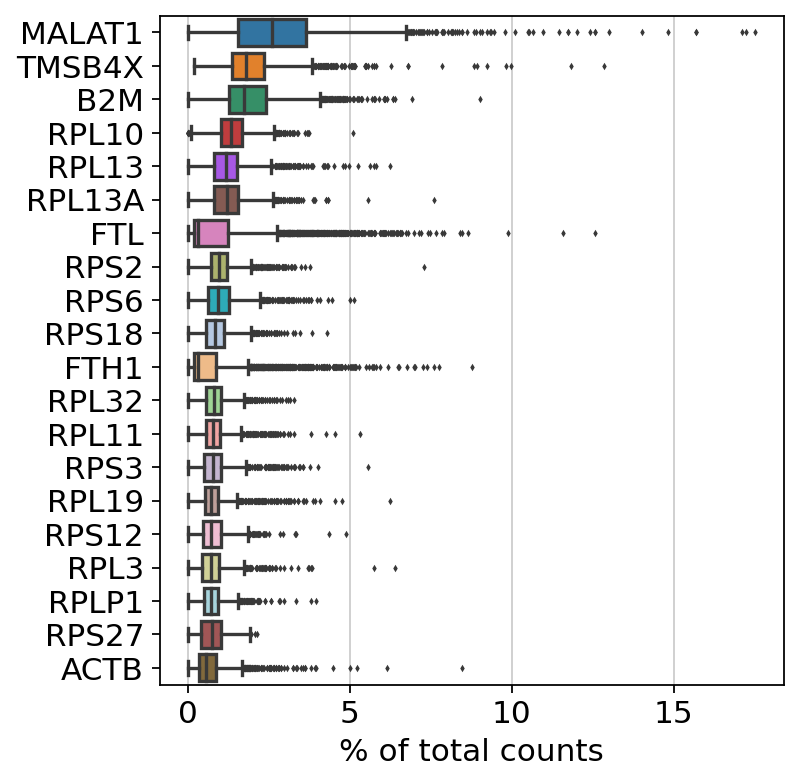

In [9]:
# sc表示scanpy，是一个包的名字
# pl表式plot作图
sc.pl.highest_expr_genes(adata, n_top=20, )
# 一个细胞中有3万种基因，把这一个细胞中的3万种基因的表达量count值加起来，
# 然后用一种基因的表达量count值除以刚才的总表达量值，得到这个基因在这个细胞中的表达量的比例值；
# 计算每一种基因在所有的细胞中的表达量占比的平均值，然后选取平均值最高的20种基因；
# 做盒须图展示每一种基因在所有细胞例如2700个细胞中各自的表达量的占比值。

Basic filtering:

In [10]:
# scanpy.preprocessing
# pp表示preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# 这种函数的效果是直接改变adata对象本身

# 名叫filter_cells()的函数，是对细胞做过滤操作，
# min_genes=200，表示一个细胞有表达的基因的种类数至少要有200种基因，少于200种基因的细胞会被过滤掉。

# 名叫filter_genes()的函数，是对基因做过滤操作，
# min_cells=3，表示一种基因至少要在3个细胞中有表达，少于3个细胞的基因会被过滤掉。

filtered out 19024 genes that are detected in less than 3 cells


In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

线粒体基因含量的比例，会作为单细胞转录组测序数据质量好坏的一种表征。

由于死细胞的细胞膜的通透性变大，细胞质中的分子，比如mRNA会流到细胞外，造成胞内的mRNA减少。但是线粒体的分子仍旧会留在线粒体内，也就是还留在细胞中。

粗略理解，线粒体基因含量高，那么就是死细胞。

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [12]:
adata.var

gene_ids  n_cells
AL627309.1     ENSG00000237683        9
AP006222.2     ENSG00000228463        3
RP11-206L10.2  ENSG00000228327        5
RP11-206L10.9  ENSG00000237491        3
LINC00115      ENSG00000225880       18
...                        ...      ...
AC145212.1     ENSG00000215750       16
AL592183.1     ENSG00000220023      323
AL354822.1     ENSG00000215615        8
PNRC2-1        ENSG00000215700      110
SRSF10-1       ENSG00000215699       69

[13714 rows x 2 columns]

In [13]:
adata.var['n_cells'].sum()

2282976

In [14]:
adata.var['n_cells'].max()
# adata.var['n_cells']中的某一个单元格的值的含义，应该是指，这一行对应的基因在多少个细胞中有表达。
# 最多在2700个细胞中有表达，也就是在所有的细胞中都有表达。

2700

In [15]:
adata.var_names
# 基因的英文简写名称

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [16]:
type(adata.var)
# adata.var是pandas的dataframe

pandas.core.frame.DataFrame

In [17]:
# var表示variable，在这里表示基因
# 在adata.var这个dataframe中新增加一列，单元格的值标注该行的基因的index即基因名是否以'MT-'开头，即是否为线粒体基因。
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt']


AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: mt, Length: 13714, dtype: bool

In [18]:
adata.obs

n_genes
AAACATACAACCAC-1      781
AAACATTGAGCTAC-1     1352
AAACATTGATCAGC-1     1131
AAACCGTGCTTCCG-1      960
AAACCGTGTATGCG-1      522
...                   ...
TTTCGAACTCTCAT-1     1155
TTTCTACTGAGGCA-1     1227
TTTCTACTTCCTCG-1      622
TTTGCATGAGAGGC-1      454
TTTGCATGCCTCAC-1      724

[2700 rows x 1 columns]

In [19]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# qc_vars=['mt']，表示对adata.var['mt']做计算。

# percent_top=None 表示取百分之多少的表达量最高的基因做计算，这里为None，表示不做计算？
# Which proportions of top genes to cover. If empty or None don't calculate. Values are considered 1-indexed, percent_top=[50] finds cumulative proportion to the 50th most expressed gene.

# log1p : bool, optional (default: True) 某种转换计算
# Set to False to skip computing log1p transformed annotations.

# inplace : bool, optional (default: False) 计算出来的值会放到adata.obs或adata.var中，在这里会改变adata.obs，使得它多了几个列
#     Whether to place calculated metrics in adata's .obs and .var.

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

In [20]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [21]:
?adata.obs

In [22]:
adata.obs
# 这是一个dataframe，里面有5列
# n_genes列中的一个单元格的数值表示，一个细胞中有多少种基因是有表达的。
# n_genes_by_counts列跟n_genes列的值很接近，但是n_genes_by_counts比n_genes略小一点，为什么？
# total_counts中的一个单元格的数值表示，一个细胞中所有基因的表达量count数之和。
# total_counts_mt中的一个单元格的数值表示，一个细胞中所有线粒体基因的表达量count数之和。
# pct_counts_mt中的一个单元格的数值表示，一个细胞中所有线粒体基因的表达量count数之和，占，这个细胞中所有基因的表达量count数之和，的比例值。

n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2700 rows x 5 columns]

In [23]:
adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100

AAACATACAACCAC-1    3.017776
AAACATTGAGCTAC-1    3.793596
AAACATTGATCAGC-1    0.889736
AAACCGTGCTTCCG-1    1.743085
AAACCGTGTATGCG-1    1.224490
                      ...   
TTTCGAACTCTCAT-1    2.110436
TTTCTACTGAGGCA-1    0.929422
TTTCTACTTCCTCG-1    2.197150
TTTGCATGAGAGGC-1    2.054795
TTTGCATGCCTCAC-1    0.806452
Length: 2700, dtype: float32

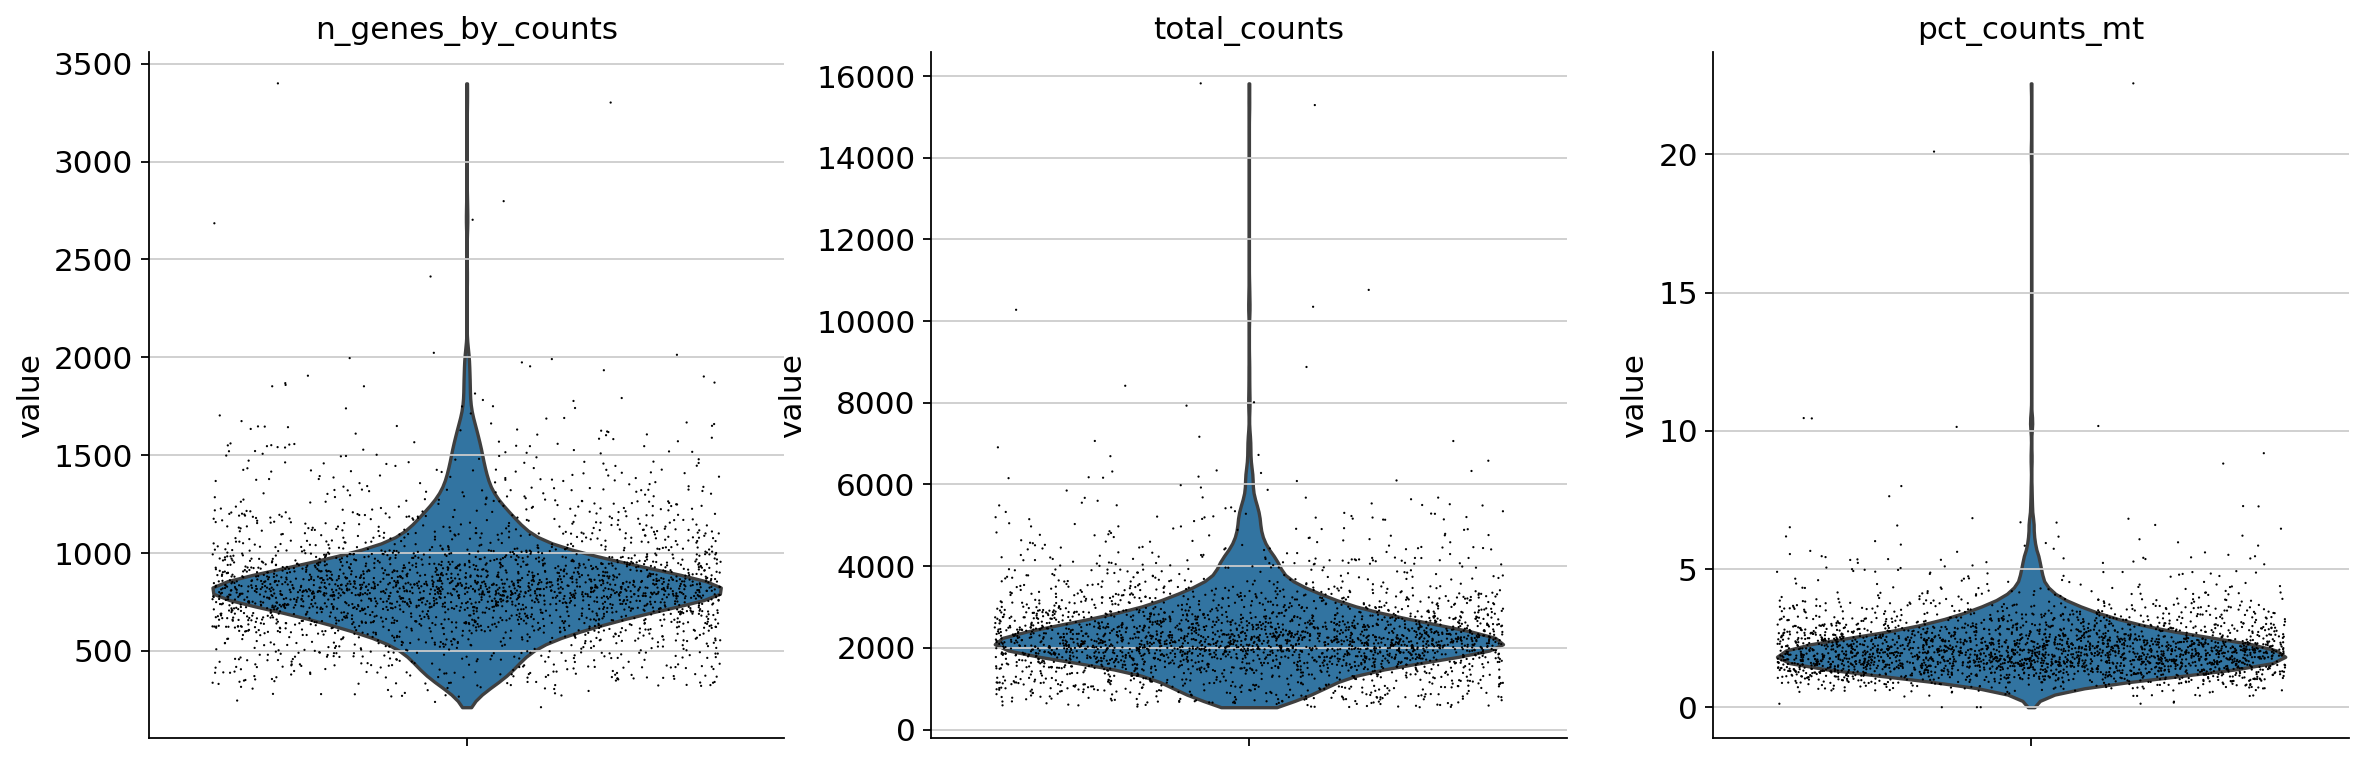

In [24]:
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True
)

# keys : typing.Union[str, typing.Sequence[str]]，这里用的是adata.obs中的3个列的列名。
#     Keys for accessing variables of .var_names or fields of .obs.

# jitter : typing.Union[float, bool], optional (default: True) 
#     Add jitter to the stripplot (only when stripplot is True) See ~seaborn.stripplot.
# 应该是设置数据点的一个随机抖动离散的幅度，避免多个数据点完全重合，看不出来是多个数据点。

# multi_panel : typing.Union[bool, NoneType], optional (default: None)
#     Display keys in multiple panels also when groupby is not None.
# 这个参数的含义是，把['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
# 这3个列的数据点分成多个小图来画，还是画在一个图中。

# 图中的每一个点代表一个细胞。
# 横轴没有数值意义。

# n_genes_by_counts图中，展示出来的结果是，比较多的细胞（点）它们的有表达的基因的种类数是1000种，
# 即大部分的细胞（点）有1000种有表达的基因。

# total_counts图中，展示出来的结果是，比较多的细胞（点）它们的各自的所有基因的总表达量counts为2000。

# pct_counts_mt图中，展示出来的结果是，比较多的细胞（点）它们的线粒体基因的含量为2.5%。

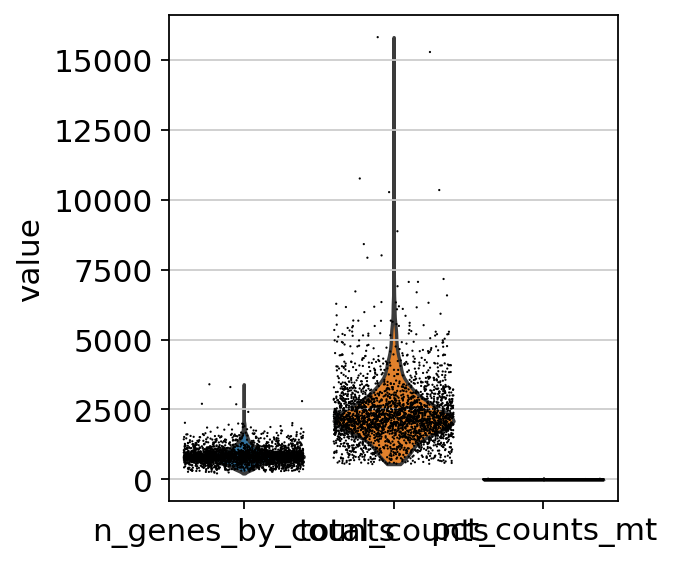

In [25]:
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=False
)
# 如果把multi_panel设置为False或None，默认值为None，那么就会把3种数值画在一个图中。
# 由于3种数值各自的取值范围差别很大，画在一个图中，则某一种数值的特征就不能展现出来，
# 特别是线粒体基因的比例值，它肯定比其他的counts值要小很多。

Remove cells that have too many mitochondrial genes expressed or too many total counts:

线粒体基因比例过大，有可能是死细胞。

基因表达量count值过大，有可能是把多个细胞的mRNA当成是1个细胞的来测序。doublet.

所以要剔除这样的数据。

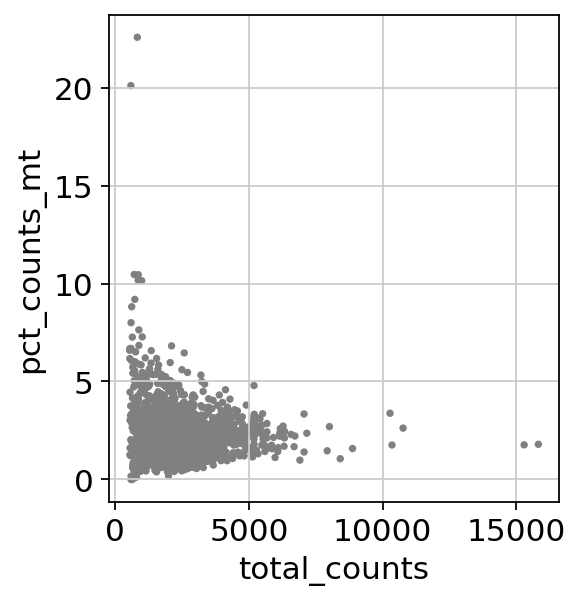

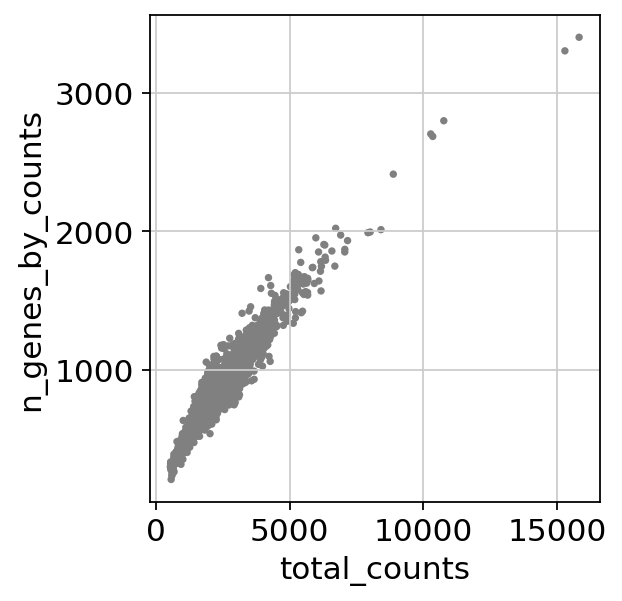

In [26]:
# sc.pl表示scanpy.plotting

# 线粒体基因的占比
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# 作图结果表明，线粒体基因的占比，不会随着一个细胞的总的基因的表达量的增多而上升。

# 有表达的基因的种类数
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
# 作图结果表明，有表达的基因的种类数，会随着一个细胞的总的基因的表达量的增多而增多。

Actually do the filtering by slicing the `AnnData` object.

把adata理解为是一个dataframe，里面的每一行代表一个细胞（observation），每一列代表一种基因（variable）。

In [27]:
adata.obs
# adata.obs是一个dataframe，里面的每一行代表一个细胞，
# 有5列: n_genes 	n_genes_by_counts 	total_counts 	total_counts_mt 	pct_counts_mt

n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2700 rows x 5 columns]

In [28]:
# 从上面的作图来看，有表达的基因的种类数，在2500以上的，这样的细胞的个数很少，属于极端情况，
# 所以可以把这样的细胞的数据给剔除掉。
# 在写条件代码做处理时，是保留，有表达的基因的种类数，在2500以下的，这样的细胞的数据行。
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# 从上面的作图来看，线粒体基因的占比，在5%以上的，这样的细胞的个数很少，属于极端情况，
# 所以可以把这样的细胞的数据给剔除掉。
# 在写条件代码做处理时，是保留，线粒体基因的占比，在5%以下的，这样的细胞的数据行。
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

# 下面是追查normalize_total()函数的源代码在做什么处理

In [29]:
?sc.pp.normalize_total

In [30]:
from scanpy.get import _get_obs_rep, _set_obs_rep
# X = adata
# copy = True
# X = X.copy() if copy else X

adata_copy = adata.copy()
layer = None
X = _get_obs_rep(adata_copy, layer=layer)
X


<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [31]:
X.copy()

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [32]:
counts_per_cell = X.sum(1)
# X有第0个维度，第1个维度。
# 这里X.sum(1)，是在第1个维度上做sum加法，也就是把所有基因的数值给合到一起。
counts_per_cell
# 算出来每一个细胞各自的所有的基因的总表达量

matrix([[2419.],
        [4903.],
        [3147.],
        ...,
        [1684.],
        [1022.],
        [1984.]], dtype=float32)

In [33]:
np.shape(counts_per_cell)

(2638, 1)

In [34]:
counts_per_cell = np.ravel(counts_per_cell)
# ravel英文单词意思是"解开，拆开缠结在一起的东西"
# np.ravel()函数的作用是，把多维度（或称多层次）结构的array或matrix，展开，
# 变成只有1个维度的array。
counts_per_cell

array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [35]:
# inplace: bool = True,
# inplace = True
# if inplace:
#     if key_added is not None:
#         adata.obs[key_added] = counts_per_cell
#     _set_obs_rep(
#         adata, _normalize_data(X, counts_per_cell, target_sum), layer=layer
#     )

In [36]:
# def _normalize_data(X, counts, after=None, copy=False):
target_sum = 1e4
X = X
counts = counts_per_cell
after = target_sum
copy = False
X = X.copy() if copy else X

    # return X

In [37]:
if issubclass(X.dtype.type, (int, np.integer)):
    X = X.astype(np.float32)  # TODO: Check if float64 should be used


In [38]:
counts = np.asarray(counts)  # dask doesn't do medians
counts

array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [39]:
# 如果前面没有传参after=target_sum ，例如1e4，即10000
# 那么after变量的值则是，对所有细胞的总的基因表达量求中位数的值，
# 也就是处于中间水平的细胞的基因的总表达量是多少。
after = None # 默认值就是None
after = np.median(counts[counts > 0], axis=0) if after is None else after
after

2213.0

In [40]:
# 如果前面传参after=target_sum ，例如1e4，即10000,
# 那么after变量，会直接被赋值为target_sum的值
target_sum = 1e4
after = target_sum
after = np.median(counts[counts > 0], axis=0) if after is None else after
after

10000.0

无论有没有传参target_sum，对于所有的细胞来说，用的是同一个after值，不会说，对细胞001用一种after值，而对细胞002用另一种after值。

In [41]:
counts == 0

array([False, False, False, ..., False, False, False])

In [42]:
0 + (counts == 0)
# 这是为了查看，在做数学运算时，python会将False或True转成什么样的数值。
# False会转成0，True会转成1.
# counts不等于0的对应False，counts等于0的对应True。

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
0 + np.array([False])

array([0])

In [44]:
0 + np.array([True])

array([1])

In [45]:
# 这个语句的含义是
# counts不等于0的则counts值保持不变，counts等于0的则counts值加1。
counts + (counts == 0)


array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [46]:
counts += counts == 0
# 等价于counts += (counts == 0)
# 等价于 counts = counts + (counts == 0)
# 因为默认输入数据counts值都是大于或等于0的，不存在负数，
# 所以经过这个语句的处理，counts值变成都是大于或等于1的，也就是说最小是1而不会是0.
# 可能是为了后面能当作分母，做除法运算。

# 总结就是，大于0的值保持不变，而等于0的值则变为1。


In [47]:
# counts += counts == 0
counts = counts / after
counts
# 先把counts缩小，变成小于1的小数。后面再除以这个小数，那么就会把值变大了。

array([0.2419, 0.4903, 0.3147, ..., 0.1684, 0.1022, 0.1984], dtype=float32)

In [48]:
from scipy.sparse import issparse
from sklearn.utils import sparsefuncs
if issparse(X):
    sparsefuncs.inplace_row_scale(X, 1 / counts)
else:
    np.divide(X, counts[:, None], out=X)

In [49]:
X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

# normalize_total()函数小结

我感觉这个sc.pp.normalize_total()标准化的处理，就是，每一种基因的表达量，除以，某一个细胞中的所有基因的总表达量，这算出来是一个比例值，也就是基因表达量的相对含量。（细节层面的话，有个遇到0则加1的处理，避免出现0值的情况）

那么对于一个细胞的各个基因的这些比例值，它们加起来，结果为1。对于所有的细胞，它们各自都是这样的。

由于这些比例值是小数，不够直观，或者不利于后面的运算处理。我们想把它们转化为大于1的数字，接近原来counts值的大小。所以我们会把这些比例值乘以一个固定的较大的数字，例如10000，或1000000.这个固定的数字对所有细胞都是一样的。我们把这样的转化后的值称为normalized_counts值。

这样，每一个细胞的所有基因的normalized_counts值之和都相等，也就是细胞001的normalized_counts.sum()，细胞002的normalized_counts.sum()，细胞003的normalized_counts.sum()，，，它们都是相等的一个值。

关于这个名字'normalize_total'，可以理解为是用total总的基因的表达量来作为分母，来做的标准化处理。

# 对adata做标准化处理

In [50]:
# sc.pp表示scanpy.preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 对标准化后的表达量数值，做ln(1+x)的对数化处理

Logarithmize the data:

In [51]:
# np.log1p(X, out=X)
# base的参数值默认为None,所以下面的if语句是不会执行的。
# if base is not None:
#     np.divide(X, np.log(base), out=X)

np.log1p()是numpy的函数，含义为log 1 plus x，即log(1+x), 默认底数为e=2.718.
可以写参数out来指定生成的结果保存到哪个变量中，一般可以用来表示对array做原位的改变操作。

In [52]:
X = np.array([1.0, 2.0, 3.0])
print(X)
print()
np.log1p(X, out=X)
print(X)

[1. 2. 3.]

[0.69314718 1.09861229 1.38629436]


In [53]:
# 对标准化后的表达量数值，做ln(1+x)的对数化处理
sc.pp.log1p(adata)
# 为什么要做对数化处理呢？是为了让数值的范围缩小一些吗？

**做ln(1+x)处理，这一步很重要，在scanpy体系中必须做。**

因为下面的标注表达量高度变化的基因的函数，期望接受的数值，就是ln(1+x)的数值，而不是原始的数值。

在下面的标注表达量高度变化的基因的函数的代码内部，会对数值做指数运算，然后减一，求出count值。如果在这里不做ln(1+x)处理的话，那么在调用标注表达量高度变化的基因的函数时，得到的数值就不对了。

### 找出在不同的细胞中表达量变化很大的基因

这里的表达量高度变化的基因，这种变异，是指相对于基因自身的表达量的平均值的变异程度，就是dispersion = variance / mean

Expects logarithmized data, except when flavor='seurat_v3' in which count data is expected.
默认情况下，需要输入的数值是对数化处理后的数值。如果是flavor='seurat_v3',则要求输入的是count值，而不是对数化的值。

In [54]:
# hvg = _highly_variable_genes_single_batch(
#     adata_subset,
#     min_disp=min_disp,
#     max_disp=max_disp,
#     min_mean=min_mean,
#     max_mean=max_mean,
#     n_top_genes=n_top_genes,
#     n_bins=n_bins,
#     flavor=flavor,
# )

In [55]:
# mean, var = materialize_as_ndarray(_get_mean_var(X))
# 计算平均值和方差
# geneA的表达量在细胞001中有1个值，在细胞002中有1个值，在细胞003中有1个值，，，
# 计算geneA的表达量在所有细胞中的平均值，以及这些表达量数值的方差。

In [56]:
# def _get_mean_var(X, *, axis=0):
#     if sparse.issparse(X):
#         mean, var = sparse_mean_variance_axis(X, axis=axis)
#     else:
#         mean = np.mean(X, axis=axis, dtype=np.float64)
#         mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
#         var = mean_sq - mean ** 2
#     # enforce R convention (unbiased estimator) for variance
#     var *= X.shape[axis] / (X.shape[axis] - 1)
#     return mean, var

In [57]:
# mean, var = materialize_as_ndarray(_get_mean_var(X))

In [58]:
# n_top_genes : typing.Union[int, NoneType], optional (default: None)
#     Number of highly-variable genes to keep. Mandatory if flavor='seurat_v3'.

# min_mean : typing.Union[float, NoneType], optional (default: 0.0125)
    # If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# max_mean : typing.Union[float, NoneType], optional (default: 3)
#     If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# min_disp : typing.Union[float, NoneType], optional (default: 0.5)
#     If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# 深入学习highly_variable_genes()函数

highly_variable_genes()函数的作用是把表达量高度变化的基因给标注出来。

期望输入的adata，它里面含对数化的数值。
但是当flavor='seurat_v3'时，应该要用count数值，而不是对数化的数值。

对于Satija15和Zheng17的基于dispersion值的方法，标准化的dispersion值，是通过缩放dispersion的平均值和标准差，对那些落入一个给定箱子的基因，对于基因的平均表达量。这意味着，对于平均表达量的每一个箱子，表达量高度变化的基因会被选出来。
这段话我不懂？

而另一种方法是Stuart19的方法，对每一种基因计算标准化的方差值。
首先，用规范化的标准差对数据做标准化（即对每一个基因做z-score标准化）。
然后，计算上述标准化后的每一个基因的方差值，这个方差值就是标准化的方差值。
对基因按照方差值的大小来排序。

具体是怎么运算的，还得看源代码。

##

函数参数的描述


adata

虽然函数定义体的doc-string中说它是一个matrix，但是我查看adata的类型，它是一个anndata._core.anndata.AnnData对象。

#

layer

默认值是None。期望传入的参数值是字符串。

在不写这个参数时，函数会读取adata.X，来作为表达量数值。
如果写了这个参数值，那么函数会读取adata.layers[layer],来作为表达量数值。

#

n_top_genes

默认值是None。期望传入的参数值是一个int整数。

保留多少个表达量高度变化的基因，用来做下游的分析。
如果是flavor='seurat_v3'，那么这个参数是必须要写的。
如果写了n_top_genes参数，那么其它的一些cutoff条件会被视为无效。

后面会提到，函数设置的默认flavor是'seurat'。

#

min_mean

默认值是0.0125。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个min_mean参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个min_mean参数就会被视为无效。

#

max_mean

默认值是3。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个max_mean参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个max_mean参数就会被视为无效。

#

min_disp

默认值是0.5。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个min_disp参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个min_disp参数就会被视为无效。

#

max_disp

默认值是np.inf，即正无穷大。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个max_disp参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个max_disp参数就会被视为无效。

#

span

默认值是0.3。期望传入的参数值是一个float浮点数。

当flavor='seurat_v3时，用来估计loess拟合模型的方差值时，用多大比例的细胞的数据来做运算。

这个函数设置的flavor默认值是'seurat'，不是'seurat_v3'。

#

n_bins

默认值是20。期望传入的参数值是一个int整数。

对多个基因的平均表达量数值做分箱，设置用多少个箱子来做分箱。
标准化是对每一个箱子而言的。
如果一个箱子中只有1个基因落进去了，那么标准化的dispersion值会被强制写为1。
如果你设置了settings.verbosity=4,那么你会看到这样的被强制写为1的信息。

#

flavor

只能写这3个中的1个: 'seurat', 'cell_ranger', 'seurat_v3'。
默认值是'seurat'。

选择用哪种风格（或方式）来识别表达量高度变化的基因。对于基于dispersion值的方法来说，Seurat选择用cutoffs的方式来圈出表达量高度变化的基因，Cell Ranger用'n_top_genes'的方式来选出表达量高度变化的基因。

#

subset

默认值是False。期望传入的参数值是bool值。

如果写subset=True,那么就会对adata对象原位保留表达量高度变化的基因，把其它的基因给删掉。
如果写subset=False,那么就只是标注出来表达量高度变化的基因，不会删掉其它基因。默认值是False，即不会删掉其它基因。

#

inplace

默认值是True。期望传入的参数值是bool值。

如果写inplace=True,则会把计算出来的结果保存到adata.var成员中，var表示variable，即基因的数据。默认值是True。
如果写inplace=False,则不会把计算出来的结果保存到adata.var成员中，而是把计算出来的结果作为函数的返回值。

#

batch_key

默认值是None。期望传入的参数值是一个字符串。

如果写了这个参数，那么表达量高度变化的基因，会在每一个batch中分别被挑选出来，然后做合并。
这个简单的处理避免（或者说过滤掉了）batch-specific批次特异性的基因，可以看作是一个轻量级的batch correction method批次校正方法。
对于各种flavor，首先会对基因排序，根据基因在多少个batch中是表达量高度变化的基因。
对于基于dispersion的flavor，ties联系会被打断，由于标准化的dispersion。
对于seurat_ve的flavor，ties联系会被打断，由于批次内的标准化的方差值，做的跨越多个批次的中位数排序。这句话是啥意思？

#

check_values

默认值是True。期望传入的参数值是一个bool值。

只有当flavor='seurat_v3'时，才能做check_values。
就是检查在选择的layer中的counts值是不是整数。
什么叫layer?


##

highly_variable_genes()函数返回值的介绍

#

函数的返回值分2种情况，取决于inplace参数值。

默认情况下，inplace参数值为True，则函数会直接更新adata.var成员，具体增加或改变的是下面的field（或称列）：

**highly_variable**: 是一列bool值，True对应的基因为表达量高度变化的基因，False对应的基因则不是表达量高度变化的基因。

**dispersions**: 只有在基于dispersion的处理方式中，才有这一列的结果，是每一种基因的dispersion值。

**dispersions_norm**: 只有在基于dispersion的处理方式中，才有这一列的结果，是每一种基因的标准化的dispersion值。

**variances**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果，是每一种基因的表达量的方差值。

**variances_norm**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果，是每一种基因的表达量的标准化的方差值。如果是多个批次，则会取平均？这我看不懂。

**highly_variable_rank**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果。根据标准化的方差值，对基因排序，基因的排序序号。如果是多个批次，则是用中位数排序方法？这我看不懂。

**highly_variable_nbatches**: 只有在写了batch_key参数后，才有这一列的结果。是一列整数，表示每一个基因，它们各自在多少个批次中被标注为表达量高度变化的基因。

**highly_variable_intersection**: 只有在写了batch_key参数后，才有这一列的结果。是一列bool值，表示每一个基因，它们各自是否在所有的批次中都被标注为表达量高度变化的基因。

##

注意，sc.pp.highly_variable_genes()函数已经取代了scanpy.pp.filter_genes_dispersion()，所以不要再使用scanpy.pp.filter_genes_dispersion()函数了。

### 下面学习sc.pp.highly_variable_genes()函数的定义体的源代码

In [59]:
n_top_genes = None,
min_disp = 0.5,
max_disp = np.inf,
min_mean = 0.0125,
max_mean = 3,

注意，在python中，给变量赋值时，后面不能加comma逗号。如果加了逗号，会变成tuple。

In [60]:
value_without_comma = None
value_with_comma = None,
print(value_without_comma)
print(value_without_comma is not None)
print(value_with_comma)
print(value_with_comma is not None)

None
False
(None,)
True


In [61]:
n_top_genes = None
min_disp = 0.5
max_disp = np.inf
min_mean = 0.0125
max_mean = 3

In [62]:
(m is None for m in [min_disp, max_disp, min_mean, max_mean])

<generator object <genexpr> at 0x7fd6afae0e50>

In [63]:
generator_m_is_None = (m is None for m in [min_disp, max_disp, min_mean, max_mean])
for m_is_None in generator_m_is_None:
  print(m_is_None)

False
False
False
False


In [64]:
all([False,False,False,False])
# 判断是否iterable中的所有元素的值都为True，如果是则返回值为True；但凡有一个元素为False，则返回值为False.
# Return True if bool(x) is True for all values x in the iterable.
# If the iterable is empty, return True.

False

In [65]:
any([True, False, False])
# 判断iterable中的元素，是否有一个元素的值为True，如果有则返回值为True；但所有元素都为False，则返回值为False.
# Return True if bool(x) is True for any x in the iterable.
# If the iterable is empty, return False.

True

In [66]:
# from .. import logging as logg

### 找python模块文件在自己服务器中的路径

在学习python包的源代码时，如何复现导入相对路径的模块呢？

把相对路径，换成我自己的服务器中的绝对路径就好了。

问题变成了找，那个源代码.py文件，在我自己的服务器中的路径位置。

在colab中，对某个函数名单击“查看源代码”，右侧面板中，右键单击“路径”，就能获得该python模块文件在自己服务器中的路径。

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py

然后自己再思考一下，.点号表示的当前路径，其实是该python模块文件所在的目录路径，双点号..表示的路径，就是再向上一级的目录路径。

找到双点号..表示的路径对应的在服务器中的绝对路径后，思考如何能写出来有效的导入语句。

由于scanpy是能直接导入的，所以scanpy所在的目录，就是一个PYTHONPATH值的路径之一，也就是说是python会去scanpy所在的目录取搜索包名或模块名。
由于导入语句，是不能写含有/的路径的，只能写点号表示所属关系，所以我们需要把绝对路径换成导入语句能识别的内容。
最终就是把..换成scanpy就行了。

In [67]:
# . = /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/
# .. = /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/..
# .. = /usr/local/lib/python3.7/dist-packages/scanpy/
# from .. import logging as logg
from scanpy import logging as logg
# /usr/local/lib/python3.7/dist-packages/scanpy/logging.py
# 可以看到logging是一个python文件，那么scanpy的作者在后面通过logg.info()的语句来调用logging.py文件中的函数或类。

In [68]:
# from /usr/local/lib/python3.7/dist-packages/scanpy/ import logging as logg

In [69]:
!pwd

/content


In [70]:
# 通过这个代码的运行结果可以看到，logg.info()函数的功能，其实是打印信息，（另外还有其它的一些作用）。
n_top_genes = 100
if n_top_genes is not None and not all(
    m is None for m in [min_disp, max_disp, min_mean, max_mean]
):
    logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')
    print('If you pass `n_top_genes`, all cutoffs are ignored.')
n_top_genes = None

If you pass `n_top_genes`, all cutoffs are ignored.
If you pass `n_top_genes`, all cutoffs are ignored.


In [71]:
# 我觉得在编程代码中，尽量使用“有"，“正向"，“正数"的语言，这样才好理解。
# 少用“没有"，“否定"的代码。
# 下面是我对scanpy的代码，改编后的代码
print(n_top_genes)
print(n_top_genes is not None)
if n_top_genes is not None and any(
    argument_value is not None
    for argument_value in [min_disp, max_disp, min_mean, max_mean]
 ):
  logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')
  # print('If you pass `n_top_genes`, all cutoffs are ignored.')

None
False


In [72]:
# # 我觉得作者的意图是，当n_top_genes有值，而且[min_disp, max_disp, min_mean, max_mean]中至少有一个元素有值时，
# # 就打印提示信息，说你现在传入了n_top_genes参数值，那么其他的cutoff会被视作无效。
# if n_top_genes is not None and not all(
#     m is None for m in [min_disp, max_disp, min_mean, max_mean]
# ):
#     logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')

# # 用is None， is not None语句来判断，是因为默认值赋值为None了。

# # 在编程语言中，“有值"，只能用“不是空值"来表示。
# if n_top_genes is not None and any(
#     argument_value is not None
#     for argument_value in [min_disp, max_disp, min_mean, max_mean]
#  )

# if n_top_genes is not None and not all(
#     m is None for m in [min_disp, max_disp, min_mean, max_mean]
# ):
#     logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')



raise ValueError()语句。

程序运行，进入到raise ValueError语句内部，执行完之后，程序就会报错退出，不会执行后面的语句。

ValueError()括号里面，可以写多个字符串，中间可以有换行，程序会自动把这多个字符串给拼接为1个字符串，显示在报错信息中。

In [73]:
# print('sentence1')
# if True:
#   raise ValueError(
#       'line1 in ValueError '
#       'line2 in ValueError'
#   )
# print('sentence after raise ValueError')

### adata的成员的简介

In [74]:
adata.X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [75]:
adata.obs

n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2638 rows x 5 columns]

In [76]:
type(adata.obs)

pandas.core.frame.DataFrame

In [77]:
adata.var

gene_ids  n_cells  ...  pct_dropout_by_counts  total_counts
AL627309.1     ENSG00000237683        9  ...              99.666667           9.0
AP006222.2     ENSG00000228463        3  ...              99.888889           3.0
RP11-206L10.2  ENSG00000228327        5  ...              99.814815           5.0
RP11-206L10.9  ENSG00000237491        3  ...              99.888889           3.0
LINC00115      ENSG00000225880       18  ...              99.333333          18.0
...                        ...      ...  ...                    ...           ...
AC145212.1     ENSG00000215750       16  ...              99.407407          18.0
AL592183.1     ENSG00000220023      323  ...              88.037037         364.0
AL354822.1     ENSG00000215615        8  ...              99.703704           8.0
PNRC2-1        ENSG00000215700      110  ...              95.925926         116.0
SRSF10-1       ENSG00000215699       69  ...              97.444444          70.0

[13714 rows x 7 columns]

In [78]:
type(adata.var)

pandas.core.frame.DataFrame

In [79]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None})])
With overloaded keys:
	['neighbors'].

In [80]:
type(adata.uns)

anndata.compat._overloaded_dict.OverloadedDict

In [81]:
adata.obs_names

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', length=2638)

In [82]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [83]:
list_of_gene_names = ['AL627309.1', 'AP006222.2', 'RP11-206L10.2']
adata_subset = adata[:, list_of_gene_names]
print(adata_subset.obs)
print('####')
print(adata_subset.var)

                  n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2638 rows x 5 

https://github1s.com/theislab/scanpy/blob/HEAD/docs/usage-principles.rst#L40-L47

At the most basic level, an :class:`~anndata.AnnData` object `adata` stores
a data matrix `adata.X`, annotation of observations
`adata.obs` and variables `adata.var` as `pd.DataFrame` and unstructured
annotation `adata.uns` as `dict`. Names of observations and
variables can be accessed via `adata.obs_names` and `adata.var_names`,
respectively. :class:`~anndata.AnnData` objects can be sliced like
dataframes, for example, `adata_subset = adata[:, list_of_gene_names]`.
For more, see this `blog post`_

通常，我们把anndata.AnnData类的一个对象命名为或叫做adata，这个adata对象有一些成员或称属性。

**adata.X**: 保存的是一个表达量数值矩阵。是一种压缩格式的数据，Compressed Sparse Row format。

**adata.obs**: 保存的是细胞的observation观测记录，就是一个pandas.core.frame.DataFrame。里面的每一行代表一个细胞，列的话，有n_genes, 	n_genes_by_counts, 	total_counts 	total_counts_mt, 	pct_counts_mt, 这些信息。

**adata.var**: 保存的是基因（或称为variable变量，或属性）的数据，也是一个pandas.core.frame.DataFrame。里面的每一行代表一种基因，列的话，有gene_ids, n_cells, mt,	n_cells_by_counts, mean_counts, pct_dropout_by_counts , total_counts, 这些信息。

**adata.uns**: 保存的是unstructured annotation，非结构化的注释，是一个基于python dict的anndata.compat._overloaded_dict.OverloadedDict，这个类的定义体就不属于scanpy包了，而是anndata包的代码了。https://github1s.com/theislab/anndata/blob/HEAD/anndata/compat/_overloaded_dict.py#L72 这个源代码网页中有描述，但是我看不懂。

**adata.obs_names**: 保存的是adata.obs的row_index，即细胞名。

**adata.var_names**: 保存的是adata.var的row_index，即基因名。

**对adata对象可以用类似dataframe的中括号切片选取语法**: adata_subset = adata[:, list_of_gene_names]，在dataframe中，这样写表示选取所有的行，以及特定的列。在adata中，每一行代表一个细胞，每一列代表一种基因。所以这样写表示，选取所有的细胞，以及特定的基因。


In [84]:
# 学习官方的函数的定义体
def highly_variable_genes(
    # adata: AnnData,
    # layer: Optional[str] = None,
    # n_top_genes: Optional[int] = None,
    # min_disp: Optional[float] = 0.5,
    # max_disp: Optional[float] = np.inf,
    # min_mean: Optional[float] = 0.0125,
    # max_mean: Optional[float] = 3,
    # span: Optional[float] = 0.3,
    # n_bins: int = 20,
    # flavor: Literal['seurat', 'cell_ranger', 'seurat_v3'] = 'seurat',
    # subset: bool = False,
    # inplace: bool = True,
    # batch_key: Optional[str] = None,
    # check_values: bool = True,
    # 
    adata,
    layer= None,
    n_top_genes = None,
    min_disp = 0.5,
    max_disp = np.inf,
    min_mean = 0.0125,
    max_mean = 3,
    span = 0.3,
    n_bins = 20,
    flavor = 'seurat',
    subset = False,
    inplace = True,
    batch_key = None,
    check_values = True,
):

    # 检查是否传入了n_top_genes参数，是否会忽略其它cutoff参数。
    # 我觉得作者的意图是，当n_top_genes有值，而且[min_disp, max_disp, min_mean, max_mean]中至少有一个元素有值时，
    # 就打印提示信息，说你现在传入了n_top_genes参数值，那么其他的cutoff会被视作无效。
    # 如果用户的传参操作没有造成“其他的cutoff会被视作无效"的影响，那么是不需要打印这条提示信息的。
    if n_top_genes is not None and not all(
        m is None for m in [min_disp, max_disp, min_mean, max_mean]
    ):
        logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')

    # 打印信息，说正在提取表达量高度变化的基因
    # logg.info()函数有自己特定的返回值
    start = logg.info('extracting highly variable genes')

    # 检查传入的adata参数值是不是一个AnnData类的对象
    # 如果不是一个AnnData类的对象，则会在屏幕上显示报错信息，退出程序。
    if not isinstance(adata, AnnData):
        raise ValueError(
            '`pp.highly_variable_genes` expects an `AnnData` argument, '
            'pass `inplace=False` if you want to return a `pd.DataFrame`.'
        )

    # flavor参数的默认值是'seurat'。
    # 如果用户传进来的flavor参数值为'seurat_v3'，
    # 那么就运行seurat_v3版本的标注表达量高度变化的基因的函数，
    # 然后结束这整个函数的程序。
    # 可以看到对seurat_v3版本的标注函数的传参过程中，确实没有传cutoff方面的参数。
    if flavor == 'seurat_v3':
      return _highly_variable_genes_seurat_v3(
          adata,
          layer=layer,
          n_top_genes=n_top_genes,
          batch_key=batch_key,
          check_values=check_values,
          span=span,
          subset=subset,
          inplace=inplace,
      )

    # 当flavor参数值不是'seurat_v3'，而是'seurat'或者'cell_ranger'时，
    # 才会运行下面的代码。

    # batch_key参数的默认值为None
    if batch_key is None:
      # 当用户不写batch_key参数时，就会调用_highly_variable_genes_single_batch()函数。
      # 从函数名来看，做的是1个批次的对表达量高度变化的基因的标注分析。
      # 也就是说，当用户不写batch_key参数时，就按照1个批次的来做分析。
      # 把函数的返回值保存到df中，看来返回值是一个dataframe。
      # 关键的一些数学计算过程应该要看这个函数的定义体。
      df = _highly_variable_genes_single_batch(
          adata,
          layer=layer,
          min_disp=min_disp,
          max_disp=max_disp,
          min_mean=min_mean,
          max_mean=max_mean,
          n_top_genes=n_top_genes,
          n_bins=n_bins,
          flavor=flavor,
      )
      # 这个df在后面会用到它，会取它其中的某些列赋值给其它的一些变量。

      # 代码中的有些地方，在colab中的右侧面板，不容易看出来一段代码究竟包括哪些行。
      # 我去github网站中看看，那里有代码区块显示功能。
      # 先找出想要查看的源代码文件在我自己的服务器中的绝对路径。然后去github网站找对应的文件夹、文件。
      # /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py
      # github网站中的网址
      # https://github.com/theislab/scanpy/blob/master/scanpy/preprocessing/_highly_variable_genes.py#L442
      # 我感觉github网站中对if else代码块也没有一个很好的显示。

      # 只能是把scanpy包下载到本地电脑，用VScode打开了。

      # 这篇知乎文章中，介绍了一种方法，可以用浏览器在线打开一个github仓库，
      # 以VScode网页版的形式来呈现代码文件内容。这样我才能单击折叠if else代码块，准确复制代码段落。
      # https://zhuanlan.zhihu.com/p/350897803 
      # 操作就是把原来的github仓库网址，在其中加入'1s'，复制粘贴到浏览器地址栏，就可以访问了。

      # https://github.com/theislab/scanpy
      # https://github1s.com/theislab/scanpy
      # 在里面也能像VScode那样，按住Ctrl，单击左键，跳转到变量定义处，但是这个有点慢，而且不一定能成功。
      # 要查看变量定义，还是在colab中，鼠标停留在变量处，选择查看源代码吧。

      # 这是另一种方法，但是对有的github仓库是不行的。不行啊，说这个仓库缺少json文件。
      # https://stackblitz.com/github.com/theislab/scanpy # 这是另一种方法，但是对有的github仓库是不行的。不行啊，说这个仓库缺少json文件。

    else:
        # 当用户写了batch_key参数时，则会执行下面的代码。
        # 其实可以先不学下面的代码，因为在初级教程中，没有写这个参数。

        # 我还学到一个python代码的知识点是，
        # 从package中导入__init__.py文件中的写着定义体的函数
        # from .._utils import sanitize_anndata, check_nonnegative_integers
        # _utils是一个文件夹的名字，并没有一个文件叫做_utils.py，
        # 而sanitize_anndata, check_nonnegative_integers函数的定义体
        # 在_utils文件夹中的__init__.py文件中，
        # 则在写导入语句的时候，就可以写从这个package中导入这2个函数，
        # python会自动从_utils文件夹中的__init__.py文件中查找这2个函数的定义体。

        # sanitize英文意思是消毒，使洁净。
        # """Transform string annotations to categoricals."""
        # 把字符串的注释，变成分类变量型的注释。
        sanitize_anndata(adata)
        batches = adata.obs[batch_key].cat.categories
        df = []
        gene_list = adata.var_names
        for batch in batches:
            adata_subset = adata[adata.obs[batch_key] == batch]

            # Filter to genes that are in the dataset
            with settings.verbosity.override(Verbosity.error):
                filt = filter_genes(adata_subset, min_cells=1, inplace=False)[0]

            adata_subset = adata_subset[:, filt]

            hvg = _highly_variable_genes_single_batch(
                adata_subset,
                min_disp=min_disp,
                max_disp=max_disp,
                min_mean=min_mean,
                max_mean=max_mean,
                n_top_genes=n_top_genes,
                n_bins=n_bins,
                flavor=flavor,
            )

            # Add 0 values for genes that were filtered out
            missing_hvg = pd.DataFrame(
                np.zeros((np.sum(~filt), len(hvg.columns))),
                columns=hvg.columns,
            )
            missing_hvg['highly_variable'] = missing_hvg['highly_variable'].astype(bool)
            missing_hvg['gene'] = gene_list[~filt]
            hvg['gene'] = adata_subset.var_names.values
            hvg = hvg.append(missing_hvg, ignore_index=True)

            # Order as before filtering
            idxs = np.concatenate((np.where(filt)[0], np.where(~filt)[0]))
            hvg = hvg.loc[np.argsort(idxs)]

            df.append(hvg)

        df = pd.concat(df, axis=0)
        df['highly_variable'] = df['highly_variable'].astype(int)
        df = df.groupby('gene').agg(
            dict(
                means=np.nanmean,
                dispersions=np.nanmean,
                dispersions_norm=np.nanmean,
                highly_variable=np.nansum,
            )
        )
        df.rename(
            columns=dict(highly_variable='highly_variable_nbatches'), inplace=True
        )
        df['highly_variable_intersection'] = df['highly_variable_nbatches'] == len(
            batches
        )

        if n_top_genes is not None:
            # sort genes by how often they selected as hvg within each batch and
            # break ties with normalized dispersion across batches
            df.sort_values(
                ['highly_variable_nbatches', 'dispersions_norm'],
                ascending=False,
                na_position='last',
                inplace=True,
            )
            df['highly_variable'] = False
            df.highly_variable.iloc[:n_top_genes] = True
            df = df.loc[adata.var_names]
        else:
            df = df.loc[adata.var_names]
            dispersion_norm = df.dispersions_norm.values
            dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
            gene_subset = np.logical_and.reduce(
                (
                    df.means > min_mean,
                    df.means < max_mean,
                    df.dispersions_norm > min_disp,
                    df.dispersions_norm < max_disp,
                )
            )
            df['highly_variable'] = gene_subset

    # 打印信息，说这个函数程序运行结束了。
    logg.info('    finished', time=start)

    # inplace默认值为True, subset默认值为False
    # 如果要改变adata本身，或者要过滤adata的数据，那么就执行下面的代码。
    # 默认情况下，是会运行下面的代码的。
    if inplace or subset:
        # 我还是看不懂这个adata.uns有什么用？
        adata.uns['hvg'] = {'flavor': flavor}

        logg.hint(
            'added\n'
            '    \'highly_variable\', boolean vector (adata.var)\n'
            '    \'means\', float vector (adata.var)\n'
            '    \'dispersions\', float vector (adata.var)\n'
            '    \'dispersions_norm\', float vector (adata.var)'
        )

        # df是前面的核新计算函数_highly_variable_genes_single_batch()的返回值。
        # 这里是把计算结果值，在adata.var（它是一个dataframe）中新增加对应的列，给保存起来。
        adata.var['highly_variable'] = df['highly_variable'].values
        adata.var['means'] = df['means'].values
        adata.var['dispersions'] = df['dispersions'].values
        adata.var['dispersions_norm'] = df['dispersions_norm'].values.astype(
            'float32', copy=False
        )
        # batch_key的默认值是None，所以不会执行下面的代码
        if batch_key is not None:
            adata.var['highly_variable_nbatches'] = df[
                'highly_variable_nbatches'
            ].values
            adata.var['highly_variable_intersection'] = df[
                'highly_variable_intersection'
            ].values
        # subset的默认值是False，所以不会执行下面的代码
        if subset:
            adata._inplace_subset_var(df['highly_variable'].values)
    else:
        # 如果进入下面的语句执行代码，那么就不会改变adata，而只是给出结果dataframe。
        return df
    


学习标注表达量高度变化的基因的核心计算代码

In [85]:
# adata: AnnData,
layer = None
n_top_genes = None
min_disp = 0.5
max_disp = np.inf
min_mean = 0.0125
max_mean = 3
# span: Optional[float] = 0.3,
n_bins = 20
flavor = 'seurat'
# subset: bool = False,
# inplace: bool = True,
# batch_key: Optional[str] = None,
# check_values: bool = True,

# /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py
from scanpy.preprocessing._highly_variable_genes import _highly_variable_genes_single_batch
df = _highly_variable_genes_single_batch(
    adata,
    layer=layer,
    min_disp=min_disp,
    max_disp=max_disp,
    min_mean=min_mean,
    max_mean=max_mean,
    n_top_genes=n_top_genes,
    n_bins=n_bins,
    flavor=flavor,
)

df

means  dispersions  ... dispersions_norm  highly_variable
0      0.013556     1.432845  ...        -0.624328            False
1      0.004696     1.458631  ...        -0.573416            False
2      0.005673     1.325459  ...        -0.836359            False
3      0.002644     0.859264  ...        -1.756848            False
4      0.027437     1.457477  ...        -0.575693            False
...         ...          ...  ...              ...              ...
13709  0.027441     1.784637  ...         0.070275            False
13710  0.485051     1.859941  ...        -0.437388            False
13711  0.012157     1.781924  ...         0.064919            False
13712  0.160366     1.567491  ...        -0.358474            False
13713  0.100255     1.544864  ...        -0.403150            False

[13714 rows x 5 columns]

_highly_variable_genes_single_batch()函数的doc-string说，它的返回值是一个dataframe，含有`highly_variable`, `means`, `dispersions`, and `dispersions_norm`这4列的数值，但是我调用这个函数得到的dataframe还多了一列数值`mean_bin`。

In [86]:
layer = None
X = adata.layers[layer] if layer is not None else adata.X
X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [87]:
adata.uns_keys()

['log1p']

In [88]:
adata.uns['log1p']

{'base': None}

In [89]:
adata.uns['log1p']['base']

In [90]:
np.e

2.718281828459045

In [91]:
np.log(np.e)
# np.log()对数函数的底数默认值是np.e，即2.718

1.0

In [92]:
np.exp(1)
# 计算e的若干次方等于多少。

2.718281828459045

In [93]:
np.expm1(np.array([1,2]))
# exp minus 1
# Calculate exp(x) - 1 for all elements in the array.
# 计算e的若干次方的值减一。

array([1.71828183, 6.3890561 ])

#### materialize_as_ndarray()

笼统地说，就是把输入，转变为numpy.ndarray。

https://docs.dask.org/en/latest/

Dask: Dynamic task scheduling

是用来实现高效的并行计算的。

使用的语法类似numpy。

In [94]:
import dask.array as da
da

<module 'dask.array' from '/usr/local/lib/python3.7/dist-packages/dask/array/__init__.py'>

In [95]:
a = [1,2]
array_a = np.asarray(a)
print(array_a)
print(type(array_a))

# np.asarray这个函数的作用是把python的普通的list或tuple转变为numpy的array，即numpy.ndarray。
# Convert the input to an array.

# Input data, in any form that can be converted to an array. 
# This includes 
# lists, 
# lists of tuples, 
# tuples, 
# tuples of tuples, 
# tuples of lists 
# and ndarrays.

[1 2]
<class 'numpy.ndarray'>


In [96]:
a = [1,2]
type(a) in (list, tuple)
tuple(np.asarray(arr) for arr in a)

(array(1), array(2))

In [97]:
# /scanpy/preprocessing/_distributed.py

import numpy as np

# install dask if available
try:
    import dask.array as da
except ImportError:
    da = None


def materialize_as_ndarray(a):
  # 这个函数的作用是，如果传入的参数是一个python的普通的list或tuple，
  # 那么把它里面的元素各自转变为一个numpy.ndarray，然后返回值是这些numpy.ndarray构成的一个tuple,
  # 如果能用dask，那么就用dask做并行计算。
  # 如果传入的参数不是list或tuple，那么就把这一个参数值转变为一个numpy.ndarray,作为返回值。
  # 笼统地说，就是把输入，转变为numpy.ndarray。
    """Convert distributed arrays to ndarrays.""" # 我不明白这句话的意思？
    if type(a) in (list, tuple):
        if da is not None and any(isinstance(arr, da.Array) for arr in a):
            return da.compute(*a, sync=True)
        return tuple(np.asarray(arr) for arr in a)
    return np.asarray(a)

#### _get_mean_var()函数

一种基因，在很多个细胞中都有表达量值，这些数值，就会有一个平均数，然后也会有一个方差。

In [98]:
X = adata.layers[layer] if layer is not None else adata.X
X = np.expm1(X)
# print(X)
from scipy import sparse
print(sparse.issparse(X))
X

True


<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

numpy的axis


In [99]:
import numpy as np
 
#creating Numpy Array
np_array_2d = np.arange(0, 6).reshape([2,3])
 
print(np_array_2d)
print('####')
 
a = np.sum(np_array_2d, axis = 0)
print(a)
print('####')

b = np.sum(np_array_2d, axis = 1)
print(b)
print('####')

# 我感觉是0表示最里面的一层，1是往外的一层。

[[0 1 2]
 [3 4 5]]
####
[3 5 7]
####
[ 3 12]
####


In [100]:
np.asarray( ([1]*9,[2]*9,[3]*9) ).reshape([3,3,3])

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]])

In [101]:
np_array_3d = np.asarray(
  [
    [
      [1, 1, 1],
      [2, 2, 2],
      [3, 3, 3]
    ],
    [
      [4, 4, 4],
      [5, 5, 5],
      [6, 6, 6]
    ],
    [
      [7, 7, 7],
      [8, 8, 8],
      [9, 9, 9]
    ],
  ]
)

In [102]:
np.add.reduce

<function ufunc.reduce>

In [103]:
import numpy as np
 
#creating Numpy Array
# np_array_3d = np.asarray( ([1]*9,[2]*9,[3]*9) ).reshape([3,3,3])
 
print(np_array_3d)
print('####')

axis_a = 0 
print(axis_a)
a = np.sum(np_array_3d, axis = axis_a)
print(a)
print('####')

axis_b = 1 
print(axis_b)
b = np.sum(np_array_3d, axis = axis_b)
print(b)
print('####')

axis_c = 2
print(axis_c)
c = np.sum(np_array_3d, axis = axis_c)
print(c)
print('####')

[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]
####
0
[[12 12 12]
 [15 15 15]
 [18 18 18]]
####
1
[[ 6  6  6]
 [15 15 15]
 [24 24 24]]
####
2
[[ 3  6  9]
 [12 15 18]
 [21 24 27]]
####


关于numpy中的沿着axis计算的介绍，有一篇知乎帖子写得很好。

https://zhuanlan.zhihu.com/p/31275071

我这里要总结的是，axis=0是指最外层的容器，axis=1是向里一层的容器，axis=2是再向里一层的容器。

在图形，形象化思考方面，要用外到内的容器的思维方式去想象。
在底层运算时，要用C++编程语言的多维数组的方式去做计算。

当选定沿着某一个维度做计算时，它的底层代码含义是，这一个维度的下标（或称索引号）会发生变化，可以理解为是做一种for循环时，递增的i或index，要用C++编程语言的多维数组去理解。我发现numpy.ndarray，也能用多维数组取值的语法，例如arrray_a[0][0][0]。

例如做sum求和运算，起始array是a,它里面有a[0][0][0]到a[2][1][3]总共`3*2*4=24`个数字,指定axis=1，这时候，首先要确定结果result_array的shape形状,相当于是消掉第1维，留下剩下的维(即原来的第0维和第2维)，应该变成了[3,4]这样的形状。然后我们就去计算这里面的每一个位置的元素的值，分别求

result_array[0][0],result_array[0][1],result_array[0][2],result_array[0][3];

result_array[1][0],result_array[1][1],result_array[1][2],result_array[1][3];

result_array[2][0],result_array[2][1],result_array[2][2],result_array[2][3]。

每一个位置的元素的求法是
result_array[0][0] = calculate_changing_index_in_that_axis__fix_other_axis(a)

即result_array[0][0] = a[0][0][0] + a[0][1][0]

##

再总结一下计算，先确定结果result_array的shape，（就是把指定的axis给消掉，剩下来的结构），然后求每一个位置的元素的值；在求某一个位置的元素的值时，固定起始array多维数组中其它维的索引号下标，变化指定的axis维的索引和下标，遍历这一维的索引号下标，完成运算。

In [104]:
array_3_2_4 = np.asarray(
    [
     [
      [1,2,3,4],
      [1,3,4,5]
     ],
     [
      [2,4,7,5],
      [8,4,3,5]
     ],
     [
      [2,5,7,3],
      [1,5,3,7]
     ],
    ]
)

In [105]:
np.sum(array_3_2_4, axis=1)
[
  [2,  5,  7,  9],
  [10,  8, 10, 10],
  [3, 10, 10, 10]
]

[[2, 5, 7, 9], [10, 8, 10, 10], [3, 10, 10, 10]]

In [106]:
a = array_3_2_4
a[0][0][0]

1

In [107]:
a[0][0][0] + a[0][1][0]

2

In [108]:
a[1][0][0] + a[1][1][0]

10

In [109]:
result_array = np.zeros(shape=[3,4])
result_array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [110]:
result_array[0][0] = a[0][0][0] + a[0][1][0]
result_array[0][0]

2.0

In [111]:
result_array[0][0] = a[0][0][0] + a[0][1][0]
result_array[0][1] = a[0][0][1] + a[0][1][1]
result_array[0][2] = a[0][0][2] + a[0][1][2]
result_array[0][3] = a[0][0][3] + a[0][1][3]
result_array

array([[2., 5., 7., 9.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### 统计学中方差的计算

https://en.wikipedia.org/wiki/Variance

变量X的数据的方差，等于，变量X的数据 的平方 的平均值，减去，变量X的数据 的平均值 的平方。

![Alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/4ad35c4161b9cf52868e879d457d8d796094ff02)

E表示Expectation期望值，我们用数据的平均值来近似这个期望值。

上面的推导中，关键看第3个等号所在的行。

把中括号打开的时候，多项式的结果的期望值，等于，每一项的期望值之和；

对乘法运算结果的期望值，等于，每一项的期望值之乘积；

对一个期望值的期望值，等于，原来的期望值本身。

In [112]:
X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [113]:
# 现在的X是Compressed Sparse Row format，所以不能使用np.multiple()函数
# np.multiply(X, X)
# 简单地把2个array，对应位置上的元素做普通的乘法运算。
# Multiply arguments element-wise.


# mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
# 这个python变量名取的不好，容易误导读者。
# 应该命名为mean_of__square_of_X, 是X数据的平方的平均值

# var = mean_sq - mean ** 2
# 每一列基因的在所有细胞中的表达量数据的方差，等于，表达量 的平方 的平均值，减去，表达量 的平均值 的平方。

对用收集的样本数据计算出来的方差值，估计总体的方差值，（无偏估计）。

In [114]:
X = adata.X
print(X)
axis = 0
print(X.shape[axis])
# 求X array的第0维上的shape是什么，也就是X array有多少行，
# 或者理解为，多维数组,X_array[][], 第1个中括号里有多少种数字，
# 同时也就是有多少个细胞。因为在scanpy中，adata的每一行代表一个细胞，每一列代表一种基因。

  (0, 29)	1.6358733
  (0, 73)	1.6358733
  (0, 80)	2.2265546
  (0, 148)	1.6358733
  (0, 163)	1.6358733
  (0, 184)	1.6358733
  (0, 186)	1.6358733
  (0, 227)	5.1386857
  (0, 229)	1.6358733
  (0, 230)	1.6358733
  (0, 231)	1.6358733
  (0, 247)	1.6358733
  (0, 266)	2.2265546
  (0, 268)	3.2505155
  (0, 328)	1.6358733
  (0, 335)	1.6358733
  (0, 360)	1.6358733
  (0, 386)	1.6358733
  (0, 398)	1.6358733
  (0, 413)	1.6358733
  (0, 436)	2.2265546
  (0, 445)	1.6358733
  (0, 466)	4.143279
  (0, 481)	1.6358733
  (0, 489)	1.6358733
  :	:
  (2637, 13352)	1.7984574
  (2637, 13355)	1.7984574
  (2637, 13367)	1.7984574
  (2637, 13393)	2.4051998
  (2637, 13406)	2.4051998
  (2637, 13436)	4.4622865
  (2637, 13450)	1.7984574
  (2637, 13452)	2.4051998
  (2637, 13458)	1.7984574
  (2637, 13463)	1.7984574
  (2637, 13464)	1.7984574
  (2637, 13477)	1.7984574
  (2637, 13526)	1.7984574
  (2637, 13530)	1.7984574
  (2637, 13567)	1.7984574
  (2637, 13602)	1.7984574
  (2637, 13635)	1.7984574
  (2637, 13648)	1.7984574
  (26

In [115]:
# var *= X.shape[axis] / (X.shape[axis] - 1)
# 等价于，var = var * ( X.shape[axis] / (X.shape[axis] - 1) )
# var = var * ( 2638/(2638-1) )

用收集的样本的数据计算出来的方差值，与，总体的方差值，有一个(n-1)/n的大小比例关系。

即，用收集的样本的数据计算出来的方差值，等于，(n-1)/n倍的，总体的方差值。

如果直接用样本的数据计算出来的方差值，来作为总体的方差值的估计值，那么这种估计值，被称为“有偏向性的估计”。
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/5da207c771e7abee61e9e7102a188d5a6c16916e)

如果对用样本的数据计算出来的方差值，乘以n/(n-1)，那么就能得到总体的方差值，这种估计值，被称为“无偏向性的估计”。

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/522b961676ec2150e830c353fb27a42b4f45afdd)

要注意的是，如果用程序计算的时候，先用样本个数n，算出来了样本的方差值，那么乘以n/(n-1)，作为总体方差无偏估计，是对的。

但是有的统计学教科书上，是在计算的时候，直接就把(n-1)作为分母来计算方差值，这样得到的是总体方差的无偏估计，就不需要再做变化了。

In [116]:
# /scanpy/preprocessing/_utils.py

import numpy as np
from scipy import sparse
import numba

def sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int):
    """
    This code and internal functions are based on sklearns
    `sparsefuncs.mean_variance_axis`.

    Modifications:
    * allow deciding on the output type, 
      which can increase accuracy when calculating the mean and variance of 32bit floats.
    * This doesn't currently implement support for null values, but could.
    * Uses numba not cython
    """
    assert axis in (0, 1)
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError("This function only works on sparse csr and csc matrices")
    if axis == ax_minor:
        return sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return sparse_mean_var_minor_axis(mtx.data, mtx.indices, *shape, np.float64)

def _get_mean_var(X, *, axis=0):
    if sparse.issparse(X):
        # 默认情况下，X是Compressed Sparse Row format，
        # 所以会执行这里的代码
        # 这里是计算平均值和方差。
        # 由于输入的数据是Compressed Sparse Row format，所以要调用相应的适用的函数去计算。
        mean, var = sparse_mean_variance_axis(X, axis=axis)
    else:
        # 不是默认情况时，则用普通的numpy函数计算平均值和方差值
        # 一般地，在scanpy中，每一行代表一个细胞（observation），每一列代表一种基因（variable）
        # 此时，axis的默认值是0，那么在运算时，结果result_array，会把第0维给消掉，只留下第1维。
        # 例如计算result_array[0] = (array_a[0][0] + array_a[1][0] + array_a[2][0]) / 3,
        # 这其实在计算第0列的平均值，也就是第0列对应的那一种基因在所有细胞中的表达量的平均值。
        # 小结，这里计算的平均值是，每一种基因各自在所有细胞中的表达量的平均值
        mean = np.mean(X, axis=axis, dtype=np.float64)
        # 计算方差，最好查一下数学公式，这里应该是用了便于计算的那个公式。
        # 还有axis=0,是指从外到里，还是从里到外的第1层？ 20211031 0：30 我理解了axis的含义。
        # axis=0是指最外面的一层，用C++多维数组的语法去理解。

        # 计算表达量的平方 的平均值
        mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
        # 每一个基因的表达量的方差，等于，表达量的平方 的平均值，减去，表达量的平均值 的平方。
        var = mean_sq - mean ** 2
    # enforce R convention (unbiased estimator) for variance
    # 这里应该是计算总体的方差值的无偏向性的估计值。前面算出来的是样本的方差值（或者说是对总体的方差值的有偏向性的估计）。
    var *= X.shape[axis] / (X.shape[axis] - 1)
    # var = var * X.shape[axis] / (X.shape[axis] - 1)

    # 这个函数的返回值，是一个tuple，里面第1个元素是mean，是一个array；第2个元素是var，是一个array。
    return mean, var

#### pandas的一些操作方法


In [117]:
import pandas as pd
import numpy as np

In [118]:
# 如果已经有一个多行多列的二维array
# 可以把这个array转化为DataFrame，然后就可以调用df的一些方法了
# 可以用这个方案，构建一些小型的基因表达量array和df

array_2d = np.array(
    [
     [1,2,3],
     [4,5,6],
     [7,8,9],
    ]
)
print(array_2d)

df = pd.DataFrame(
    data=array_2d,
    columns=['a','b','c'] # 给df赋予每一列的列名
    # array中的列，就是df中的列
)
print(df)



[[1 2 3]
 [4 5 6]
 [7 8 9]]
   a  b  c
0  1  2  3
1  4  5  6
2  7  8  9


In [119]:
means_dispersions_array = np.array(
    [
      [10,2],
      [11,3],
      [12,2],
      [11,1],
      [14,2],
    ]
)
df = pd.DataFrame(
    data=means_dispersions_array,
    columns=['means', 'dispersions']
)
print(df)

   means  dispersions
0     10            2
1     11            3
2     12            2
3     11            1
4     14            2


#### pd.cut()函数

In [120]:
n_bins = 20
df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
print(df['mean_bin'])
print(df)

# Bin values into discrete intervals.
# pd.cut(x=array_1d, bins=how_many_bins)
# 把一维array的值做分箱，分到不停的区间中，
# bins参数值是将要分到多少个箱子中
print( type(pd.cut(df['means'], bins=n_bins)) )
print( type(pd.cut(df['means'], bins=n_bins)[0] ) )
# pd.cut()函数的返回值是一个pandas的Series，
# 这个Series中的每一个元素是一个pandas的Interval区间。

# 小结
# 它把一维array中的值做分箱，分到n个区间（箱子）中，
# 所有区间的大小是相等的，区间与区间是紧挨着的，
# 但是print()显示的时候，不含数值的区间给省略了
# 返回值就是这些区间所构成的一个Series。

0    (9.996, 10.2]
1     (10.8, 11.0]
2     (11.8, 12.0]
3     (10.8, 11.0]
4     (13.8, 14.0]
Name: mean_bin, dtype: category
Categories (20, interval[float64]): [(9.996, 10.2] < (10.2, 10.4] < (10.4, 10.6] < (10.6, 10.8] < ... <
                                     (13.2, 13.4] < (13.4, 13.6] < (13.6, 13.8] < (13.8, 14.0]]
   means  dispersions       mean_bin
0     10            2  (9.996, 10.2]
1     11            3   (10.8, 11.0]
2     12            2   (11.8, 12.0]
3     11            1   (10.8, 11.0]
4     14            2   (13.8, 14.0]
<class 'pandas.core.series.Series'>
<class 'pandas._libs.interval.Interval'>


#### df.groupby()函数

一般要跟mean(), std()等统计方法联合使用

In [121]:
disp_grouped = df.groupby('mean_bin')['dispersions']
# mean_bin列中值相同的数据行，把它们视为一个group，
# mean_bin列中有多少种不同的值，就会有多少个group。
# 下游一般要分别在每一个group内部做统计运算，
# 所以这里的['dispersions']是指定对df中的哪一列的数值做统计运算。
print(disp_grouped)

In [122]:
disp_mean_bin = disp_grouped.mean()

In [123]:
print(df)
# 注意(10.8, 11.0]
# (3+1)/2 = 2

   means  dispersions       mean_bin
0     10            2  (9.996, 10.2]
1     11            3   (10.8, 11.0]
2     12            2   (11.8, 12.0]
3     11            1   (10.8, 11.0]
4     14            2   (13.8, 14.0]


In [124]:
print(disp_mean_bin)
# 这里看到(10.2, 10.4]     NaN

mean_bin
(9.996, 10.2]    2.0
(10.2, 10.4]     NaN
(10.4, 10.6]     NaN
(10.6, 10.8]     NaN
(10.8, 11.0]     2.0
(11.0, 11.2]     NaN
(11.2, 11.4]     NaN
(11.4, 11.6]     NaN
(11.6, 11.8]     NaN
(11.8, 12.0]     2.0
(12.0, 12.2]     NaN
(12.2, 12.4]     NaN
(12.4, 12.6]     NaN
(12.6, 12.8]     NaN
(12.8, 13.0]     NaN
(13.0, 13.2]     NaN
(13.2, 13.4]     NaN
(13.4, 13.6]     NaN
(13.6, 13.8]     NaN
(13.8, 14.0]     2.0
Name: dispersions, dtype: float64


In [125]:
disp_std_bin = disp_grouped.std(ddof=1)
print(disp_std_bin)
print(type(disp_std_bin))
# disp_grouped.std(ddof=1)的返回值是一个Series

mean_bin
(9.996, 10.2]         NaN
(10.2, 10.4]          NaN
(10.4, 10.6]          NaN
(10.6, 10.8]          NaN
(10.8, 11.0]     1.414214
(11.0, 11.2]          NaN
(11.2, 11.4]          NaN
(11.4, 11.6]          NaN
(11.6, 11.8]          NaN
(11.8, 12.0]          NaN
(12.0, 12.2]          NaN
(12.2, 12.4]          NaN
(12.4, 12.6]          NaN
(12.6, 12.8]          NaN
(12.8, 13.0]          NaN
(13.0, 13.2]          NaN
(13.2, 13.4]          NaN
(13.4, 13.6]          NaN
(13.6, 13.8]          NaN
(13.8, 14.0]          NaN
Name: dispersions, dtype: float64
<class 'pandas.core.series.Series'>


In [126]:
?pd.DataFrame.std
# 计算样本标准差。
# 默认情况下，会除以(N-1)，来对标准差做标准化。
# N是元素的个数。
# 参数ddof，表示Delta Degrees of Freedom，默认值为1，
# 如果用户写ddof=2, 用会除以(N-2)，来对标准差做标准化。

# Return sample standard deviation over requested axis.
# Normalized by N-1 by default. This can be changed using the ddof argument
# 
# ddof : int, default 1
#     Delta Degrees of Freedom. The divisor used in calculations is N - ddof,
#     where N represents the number of elements.

In [127]:
disp_grouped = df.groupby('mean_bin')['dispersions']
disp_mean_bin = disp_grouped.mean()
disp_std_bin = disp_grouped.std(ddof=1)

#### Series.isnull()方法

Series.isnull(series_01)的返回值是一个Series，
里面的元素是bool变量，表明原来的series_01中哪些位置的元素是np.nan

In [128]:
import pandas as pd
import numpy as np
series_1 = pd.Series(data=[1,2,3,np.nan,5])
print(series_1)

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
dtype: float64


In [129]:
print(series_1.isnull())
print(type(series_1.isnull()))
# Series.isnull(series_01)的返回值是一个Series，
# 里面的元素是bool变量，表明原来series_01中哪些位置的元素是np.nan

0    False
1    False
2    False
3     True
4    False
dtype: bool
<class 'pandas.core.series.Series'>


In [130]:
one_gene_per_bin = disp_std_bin.isnull()
print(one_gene_per_bin)
# 这里保存到名为one_gene_per_bin的变量中，
# 是因为如果标准差的值为np.nan，则表明原来在某一个箱子中只有1个基因的数据，没法计算标准差。

mean_bin
(9.996, 10.2]     True
(10.2, 10.4]      True
(10.4, 10.6]      True
(10.6, 10.8]      True
(10.8, 11.0]     False
(11.0, 11.2]      True
(11.2, 11.4]      True
(11.4, 11.6]      True
(11.6, 11.8]      True
(11.8, 12.0]      True
(12.0, 12.2]      True
(12.2, 12.4]      True
(12.4, 12.6]      True
(12.6, 12.8]      True
(12.8, 13.0]      True
(13.0, 13.2]      True
(13.2, 13.4]      True
(13.4, 13.6]      True
(13.6, 13.8]      True
(13.8, 14.0]      True
Name: dispersions, dtype: bool


#### Series.values 成员或称属性

In [131]:
df['mean_bin'].values
# 保存的是Series的原始的值

[(9.996, 10.2], (10.8, 11.0], (11.8, 12.0], (10.8, 11.0], (13.8, 14.0]]
Categories (20, interval[float64]): [(9.996, 10.2] < (10.2, 10.4] < (10.4, 10.6] < (10.6, 10.8] < ... <
                                     (13.2, 13.4] < (13.4, 13.6] < (13.6, 13.8] < (13.8, 14.0]]

In [132]:
print(type(df['mean_bin'].values))
# 是array，而且是这个array里面的元素值是categorical分类变量类型的。

<class 'pandas.core.arrays.categorical.Categorical'>


In [133]:
one_gene_per_bin[df['mean_bin'].values]
# df['mean_bin'].values 相当于是取了一些index出来，
# 也就是说，我们只要有真实数据值落入的箱子，而不要空箱子。
# 而one_gene_per_bin[]，就是只取对应index的元素的值。
# 总体而言，这个代码的意思是，
# 对于有真实数据值落入的箱子，它们各自是否为只有1个gene落入，
# 是则为True，否则为False

mean_bin
(9.996, 10.2]     True
(10.8, 11.0]     False
(11.8, 12.0]      True
(10.8, 11.0]     False
(13.8, 14.0]      True
Name: dispersions, dtype: bool

#### np.where()函数

In [134]:
?np.where

https://numpy.org/doc/stable/reference/generated/numpy.where.html

`numpy.where(condition[, x, y])`

这个函数可以接收3个参数,condition, x, y;也可以只接收1个参数condition。

condition是一个类似array的数据结构，里面存的是bool值。

如果只写了condition 这一个参数值，那么就等同于代码`np.asarray(condition).nonzero()`

When only condition is provided, this function is a shorthand for `np.asarray(condition).nonzero()`. 

condition: array_like, bool
    Where True, yield x, otherwise yield y.



In [135]:
one_gene_per_bin[df['mean_bin'].values]

mean_bin
(9.996, 10.2]     True
(10.8, 11.0]     False
(11.8, 12.0]      True
(10.8, 11.0]     False
(13.8, 14.0]      True
Name: dispersions, dtype: bool

In [136]:
np.where(one_gene_per_bin[df['mean_bin'].values])
# 

(array([0, 2, 4]),)

#### numpy.nonzero()函数

https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html

返回值是一个tuple，里面的每一个元素，是一个array，每一个array对应着原来的输入input_array中的一个维度，这个array里面保存的是index的值，原来输入的input_array某一个维度中,那些不为0的值对应的index，就保存到这里来。

也就是说这个函数的意义是，求不为0的值的index，而返回值形式是tuple里面装着若干个array，每一个array对应着input_array中的一个维度。

Return the indices of the elements that are non-zero.

Returns a tuple of arrays, one for each dimension of a, containing the indices of the non-zero elements in that dimension. The values in a are always tested and returned in row-major, C-style order.

In [137]:
np.asarray(one_gene_per_bin[df['mean_bin'].values]).nonzero()

(array([0, 2, 4]),)

In [138]:
one_gene_per_bin = disp_std_bin.isnull()
gen_indices = np.where(one_gene_per_bin[df['mean_bin'].values])[0].tolist()
# 就是为了得到one_gene_per_bin[df['mean_bin'].values 的不为0的值的index，
# 而one_gene_per_bin[df['mean_bin'].values 的不为0的值，表示箱子中只有1个基因，没法计算标准差。
print(gen_indices)

[0, 2, 4]


#### np.logical_and.reduce()函数

https://numpy.org/doc/stable/reference/generated/numpy.ufunc.reduce.html

这个函数理解起来比较困难。

For example, `add.reduce(array_2D)` is equivalent to `sum(array_2D)`.

In [139]:
?np.logical_and.reduce()

In [140]:
# gene_subset = np.logical_and.reduce(
#     (
#         mean > min_mean,
#         mean < max_mean,
#         dispersion_norm > min_disp,
#         dispersion_norm < max_disp,
#     )
# )

In [141]:
# 等价于下面
np.logical_and.reduce(
    (
        np.array([True, False, True]),
        np.array([True, True, True]),
        np.array([False, True, True]),
        np.array([False, False, True]),
    )
)

array([False, False,  True])

In [142]:
# 等价于下面
np.logical_and.reduce(
    np.array(
        [
            [True, False, True],
            [True, True, True],
            [False, True, True],
            [False, False, True],
        ]
    )
)
# 可以把这种代码理解为，对每一列求"逻辑与"运算，
# 最终得到的是一个一维的array，里面的每一个元素值是每一列的列内运算结果。

array([False, False,  True])

In [143]:
import anndata
# import AnnData

In [144]:
from anndata import AnnData

In [145]:
def _highly_variable_genes_single_batch(
    # 我注释掉原始的说明参数值类型的代码，是因为它们在我运行代码时会报错。
    # adata: AnnData,
    # layer: Optional[str] = None,
    # min_disp: Optional[float] = 0.5,
    # max_disp: Optional[float] = np.inf,
    # min_mean: Optional[float] = 0.0125,
    # max_mean: Optional[float] = 3,
    # n_top_genes: Optional[int] = None,
    # n_bins: int = 20,
    # flavor: Literal['seurat', 'cell_ranger'] = 'seurat',
    adata,
    layer = None,
    min_disp = 0.5,
    max_disp = np.inf,
    min_mean = 0.0125,
    max_mean = 3,
    n_top_genes = None,
    n_bins = 20,
    flavor = 'seurat',
) -> pd.DataFrame:
    """\
    See `highly_variable_genes`.

    Returns
    -------
    A DataFrame that contains the columns
    `highly_variable`, `means`, `dispersions`, and `dispersions_norm`.
    """
    # layer的默认值为None，所以会把adata.X赋值给变量X，adata.X是一种压缩格式的表达量矩阵。
    X = adata.layers[layer] if layer is not None else adata.X

    # flavor的默认值是'seurat'，所以会执行下面的代码。
    # 主要目的是获得原来的count值
    if flavor == 'seurat':
        # 默认情况下，adata.uns_keys()中有'log1p'，
        # adata.uns['log1p']['base']为None.
        # 也就是说当有log1plusX函数时，而且有明确的对数的底数时，就用这个底数来做运算，
        # 但是我看不懂这里写的运算是等同于ln(1+X)吗？
        # 由于默认情况下，没有明确的对数的底数，所以是不执行这个代码的。
        if 'log1p' in adata.uns_keys() and adata.uns['log1p']['base'] is not None:
            X *= np.log(adata.uns['log1p']['base'])
            # X = X * np.log(adata.uns['log1p']['base'])

        # 前面的X 是ln(1+count)算出来的，
        # 现在把X做e的X次方运算得到1+count，然后减一，得到count值。
        X = np.expm1(X)

    # _get_mean_var(X)计算得到每一个基因自己在所有细胞中表达量的平均值，以及表达量的方差（是对总体的无偏估计值）,返回值是(mean, var)
    # materialize_as_ndarray()把输入的一个tuple中的元素各自转变为一个numpy.ndarray，然后返回值是这些numpy.ndarray构成的一个tuple
    mean, var = materialize_as_ndarray(_get_mean_var(X))

    # now actually compute the dispersion
    # 下面开始计算dispersion值

    # 对于表达量平均值等于0的基因，把这些表达量值修改为一个大于0的很小的数字，10的负12次方
    mean[mean == 0] = 1e-12  # set entries equal to zero to small value
    # 基因表达量的dispersion值，等于，表达量的方差值（对总体的无偏估计值），除以，表达量的平均值。
    # 其意义是对方差值做校正，因为一般平均值大的基因，计算出来方差值也会较大，
    # 因此为了减小由于平均值的差别带来的方差值大小的不同的影响，我们对方差值除以平均值，来表征数据的相对离散情况，
    # 称之为dispersion值。于是在不同的基因间，这个disperson值可以拿来做比较。
    dispersion = var / mean
    # 计算dispersion时，用的是原始的count值，而不是对数化的值。
    # 但是后面，如果是默认的Seurat分析体系，会把dispersion值先做对数化处理。

    # flavor默认值为'seurat'，所以会执行下面的代码
    # 在Seurat分析体系中，要把dispersion和mean做对数化处理。
    # 如果不是Seurat分析体系，则不做对数化处理，而是用原来的值。
    if flavor == 'seurat':  # logarithmized mean as in Seurat
        # 如果基因在所有细胞中的表达量都相等的话，会导致方差为0，然后计算出来的dispersion值也会为0。
        # 但是我不明白，为什么要把dispersion值为0的给重新赋值为np.nan？这是Seurat分析体系的要求吗？
        # 下面要做ln对数运算，确实不能有0值出现。
        # 但是作者不使用加1的方法处理，是因为担心加1对计算结果影响过大吗？
        # 所以干脆选择，让有0值的地方，都变成np.nan。
        dispersion[dispersion == 0] = np.nan
        # 在Seurat分析体系中，用的是对数化的值，所以这里把dispersion值重新赋值为ln对数值
        dispersion = np.log(dispersion)
        # 基因的表达量平均值有可能为0，所以要做加1处理，计算ln(1+mean)
        mean = np.log1p(mean)

        # 这里已经把dispersion和mean做了对数化处理。

    # all of the following quantities are "per-gene" here
    # 构建一个dataframe，里面有2列，
    # 一列是means平均数（是不是对数化的值要看flavor是不是'seurat'），
    # 一列是dispersions值（是不是对数化的值要看flavor是不是'seurat'）。
    df = pd.DataFrame()
    df['means'] = mean # mean是一维array
    df['dispersions'] = dispersion # dispersion是一维array

    # flavor默认值为'seurat'，所以会执行下面的代码
    if flavor == 'seurat':
        # n_bins默认值是20
        # 把基因表达量平均值，分成20个区间或称箱子
        df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
        # 在每一个箱子内部，对dispersions值做统计运算
        disp_grouped = df.groupby('mean_bin')['dispersions']
        # 计算每一个箱子内部的所有基因的dispersions的平均值
        disp_mean_bin = disp_grouped.mean()
        # 计算每一个箱子内部的所有基因的dispersions的标准差，除(N-1)来做标准化。
        disp_std_bin = disp_grouped.std(ddof=1)

        # retrieve those genes that have nan std, these are the ones where
        # only a single gene fell in the bin and implicitly set them to have
        # a normalized disperion of 1
        one_gene_per_bin = disp_std_bin.isnull()
        gen_indices = np.where(one_gene_per_bin[df['mean_bin'].values])[0].tolist()
        if len(gen_indices) > 0:
            logg.debug(
                f'Gene indices {gen_indices} fell into a single bin: their '
                'normalized dispersion was set to 1.\n    '
                'Decreasing `n_bins` will likely avoid this effect.'
            )
        # Circumvent pandas 0.23 bug. Both sides of the assignment have dtype==float32,
        # but there’s still a dtype error without “.value”.
        disp_std_bin[one_gene_per_bin.values] = disp_mean_bin[
            one_gene_per_bin.values
        ].values
        # 这是把只含一个基因的箱子的箱内dispersion平均值，赋值给了，
        # 这个箱子的箱内dispersion标准差。
        # 为什么这么做？作者的代码注释中，说的是设为1啊？
        # 总之，作者把只含一个基因的箱子的箱内dispersion的标准差值，设为了，箱内dispersion的平均值。

        # 一个容易搞混的地方。
        # dispersion = variation/mean, 
        # 就算只有1个基因，也能计算variation和mean，
        # 因为是这1个基因在所有细胞中的表达量的variation和mean,
        # 也就是说，每一个基因都有自己的variation和mean。

        # 然后把只含一个基因的箱子的箱内dispersion平均值设成0.
        disp_mean_bin[one_gene_per_bin.values] = 0

        # 在df中会新增加'dispersions_norm'这一列，
        # 里面的每一行是每一个基因的标准化的dispersion值
        # actually do the normalization
        df['dispersions_norm'] = (
            df['dispersions'].values  # use values here as index differs
            - disp_mean_bin[df['mean_bin'].values].values
        ) / disp_std_bin[df['mean_bin'].values].values
        # 每一个基因的标准化的dispersion值的计算方法，
        # 就是每一个基因的dispersion值，减去这个基因所在的箱子的dispersion的平均值，
        # 然后除以这个基因所在的箱子的dispersion的标准差值。
        # 这跟我以前学的PCA或聚类热图中的标准化的方法是类似的，
        # 这里的不同之处在于，减去的平均值，不是所有样本数据的平均值，而是某一个小箱子的箱内平均值；
        # 除以标准差，不是所有样本数据的标准差，而是某一个小箱子的箱内标准差。

        # 看完这个normalization标准化方法，我才明白上面，
        # 为什么把只含一个基因的箱子的dispersion值的箱内标准差设成了箱内平均值，
        # 然后把箱内平均值设成0,
        # 把这些数值代入上面的通用的normalization式子中，其实就变成了，
        # 这一个基因的dispersion值，减去0，然后除以这一个基因的dispersion值的平均值，
        # 其实就是,这一个基因的dispersion值,除以，这一个基因的dispersion值，最终等于1.

    elif flavor == 'cell_ranger':
        from statsmodels import robust

        df['mean_bin'] = pd.cut(
            df['means'],
            np.r_[-np.inf, np.percentile(df['means'], np.arange(10, 105, 5)), np.inf],
        )
        disp_grouped = df.groupby('mean_bin')['dispersions']
        disp_median_bin = disp_grouped.median()
        # the next line raises the warning: "Mean of empty slice"
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disp_mad_bin = disp_grouped.apply(robust.mad)
            df['dispersions_norm'] = (
                df['dispersions'].values - disp_median_bin[df['mean_bin'].values].values
            ) / disp_mad_bin[df['mean_bin'].values].values
    else:
        raise ValueError('`flavor` needs to be "seurat" or "cell_ranger"')

    dispersion_norm = df['dispersions_norm'].values

    if n_top_genes is not None:
        # n_top_genes的默认值是None，所以下面的代码在默认情况下是不会执行的。
        dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
        dispersion_norm[
            ::-1
        ].sort()  # interestingly, np.argpartition is slightly slower
        if n_top_genes > adata.n_vars:
            logg.info('`n_top_genes` > `adata.n_var`, returning all genes.')
            n_top_genes = adata.n_vars
        disp_cut_off = dispersion_norm[n_top_genes - 1]
        gene_subset = np.nan_to_num(df['dispersions_norm'].values) >= disp_cut_off
        logg.debug(
            f'the {n_top_genes} top genes correspond to a '
            f'normalized dispersion cutoff of {disp_cut_off}'
        )
    else:
        # 把一些无法计算出来的基因的标准化的dispersion值，设为0.
        dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat

        # 下面是做，根据函数接收的参数，对基因数据行做筛选保留。
        # mean是在这整个大函数中，前面已经生成的array，每一个元素值表示一个基因在所有细胞中的表达量的平均值。
        # dispersion_norm是在这整个大函数中，前面已经生成的array，每一个元素值表示一个基因在所有细胞中的表达量的标准化的dispersion值。
        # 默认情况下，
        # min_mean = 0.0125,
        # max_mean = 3,
        # min_disp = 0.5,
        # max_disp = np.inf,
        gene_subset = np.logical_and.reduce(
            (
                mean > min_mean,
                mean < max_mean,
                dispersion_norm > min_disp,
                dispersion_norm < max_disp,
            )
        )
        # 也就是说，最终被标注为是表达量高度变化的基因的条件是，
        # 基因在所有细胞中的表达量的平均值，要在给定参数的最小值到最大值的范围内，即0.0125到3之间；
        # 而且，基因在所有细胞中的表达量的标准化的dispersion值，要在给定参数的最小值到最大值的范围内，即0.5到正无穷大之间。

        # 回顾一下，这里的表达量的平均值，对应的是原始的count的数值，还是标准化后的数值？
        # 从源代码看，mean和dispersion都是ln对数化处理后的数值。
        # 所以我们在调用函数，传参时要注意，给的筛选条件，是针对ln对数化处理后的数值的。

        # gene_subset是一个array，里面是bool值，
        # True表示这个基因被标注为是表达量高度变化的基因，
        # False表示这个基因被标注为不是表达量高度变化的基因。

    df['highly_variable'] = gene_subset
    return df


### 内部函数_highly_variable_genes_single_batch()

#### 被标注为是表达量高度变化的基因的条件

基因在所有细胞中的表达量的平均值，要在给定参数的最小值到最大值的范围内，即0.0125到3之间；

而且，基因在所有细胞中的表达量的标准化的dispersion值，要在给定参数的最小值到最大值的范围内，即0.5到正无穷大之间。

#

做条件判断时，针对的mean和dispersion数值都是ln对数化处理后的数值。
所以我们在调用函数，传参时要注意，给的筛选条件，是针对ln对数化处理后的数值的。但是一般情况下，我们可以不写参数值，直接用默认值就好。

#### 每一个基因的表达量的dispersion值的计算方法

dispersion = variance / mean

一个基因在所有细胞中表达量的方差值，除以，平均值。

用的variance和mean是，基因表达量的原始的count值计算出来的，而不是对数化处理后的值。

算出来dispersion值后，会立即做ln对数化处理，用对数化的值来作为最新的dispersion值。

#### 每一个基因的标准化的dispersion值的计算方法

就是每一个基因的dispersion值，减去这个基因所在的箱子的dispersion的平均值，
然后除以这个基因所在的箱子的dispersion的标准差值。

这跟我以前学的PCA或聚类热图中的标准化的方法是类似的。

这里的不同之处在于，减去的平均值，不是所有样本数据的平均值，而是某一个小箱子的箱内平均值；
除以标准差，不是所有样本数据的标准差，而是某一个小箱子的箱内标准差。

默认情况下，分成20个小箱子。

如果一个基因，它所在的箱子中就只含有这一个基因，那么这个基因的标准化的dispersion值，会被设为1.

In [146]:
type(adata)

anndata._core.anndata.AnnData

In [147]:
# scanpy.preprocessing
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 这几个参数是什么意思？
# 我感觉它们的意思是，只有满足条件，表达量平均值，在0.0125到3之间的，dispersion值不能小于0.5的，
# 这些基因才有可能被标注为表达量高度变化的基因，才被拿去做下游的降维分析。

# Annotate highly variable genes
# 这个函数的作用是对在不同的细胞中的表达量变化很大的基因作标注。

# **means**
#     means per gene


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


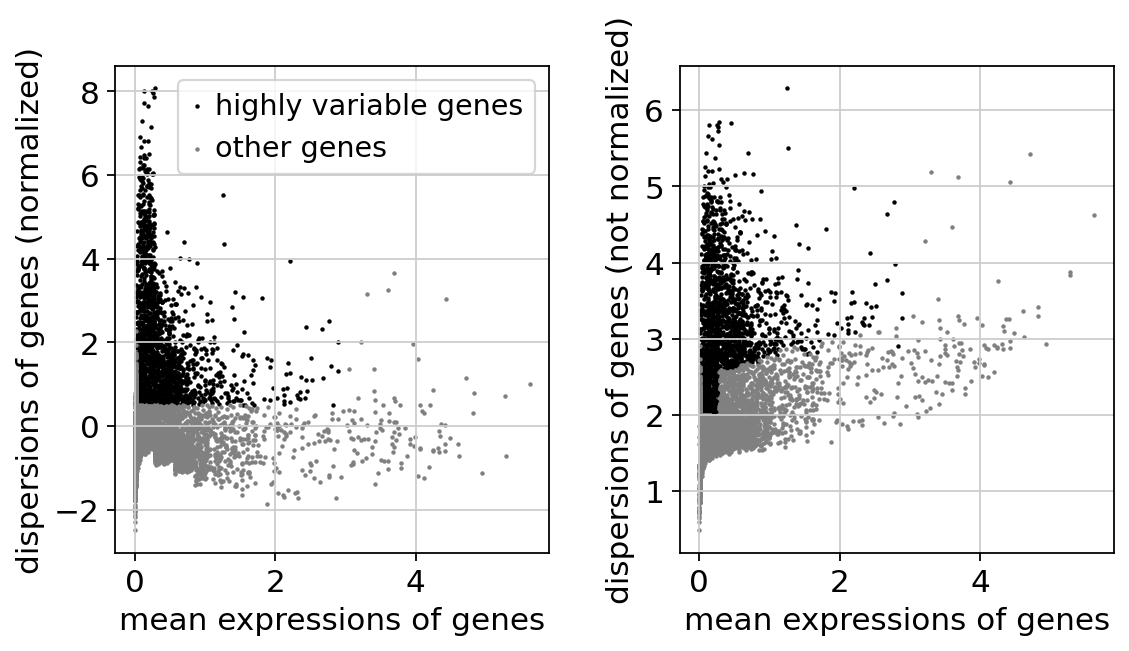

In [148]:
# scanpy.plotting
sc.pl.highly_variable_genes(adata)
# 我对这个图的理解是
# 每一个点代表一种基因，
# 横坐标的值表示这一种基因在所有细胞中的表达量的平均值，
# 纵坐标的值表示这一种基因在所有细胞中的表达量的离散程度dispersion。
# dispersion和variance方差是一回事吗？是两个东西。

# 在_highly_variable_genes_single_batch()函数的定义体中，
# dispersion等于方差除以平均值，也就是说这算出来的是一种相对离散程度，
# 因为一般情况中，平均值越大的，算出来的方差的绝对值也会越大，
# 为了抵消这种影响，于是对方差除以平均值。
    # # now actually compute the dispersion
    # mean[mean == 0] = 1e-12  # set entries equal to zero to small value
    # dispersion = var / mean

# normalized 的图中为什么，dispersion值会有负数呢？
# 它这个normalized是指center化吗，那平均值也是0啊？

# 这里的normalized和not normalized是指前面的计算相对含量的标准化操作，
# 还是这里的highly_variable_genes()函数内部做了什么新的标准化操作？

# Plot dispersions or normalized variance versus means for genes.
# Produces Supp. Fig. 5c of Zheng et al. (2017) and MeanVarPlot() and VariableFeaturePlot() of Seurat.

# 这2个函数确实不懂。

# 20211108 我通过查阅、学习源代码，得知，对dispersion值做normalize操作，
# 就是类似，把基因的dispersion值减去平均值，然后除以标准差；
# 只不过，scanpy体系里，用了分箱的策略来做normalize，
# 也就是，平均值是这一个基因所在的箱子内的平均值，标准差是箱子内的标准。

# 在判定一个基因是否为表达量高度变化的基因式，看的是这个基因在所有细胞的平均表达量，以及标准化的dispersion值，
# 而不是原始的dispersion值
# 被标注为是表达量高度变化的基因的条件：
# 基因在所有细胞中的表达量的平均值，要在给定参数的最小值到最大值的范围内，即0.0125到3之间；
# 而且，基因在所有细胞中的表达量的标准化的dispersion值，要在给定参数的最小值到最大值的范围内，即0.5到正无穷大之间。
# 所以，在用标准化的dispersion值作图的图中（左图），表达量高度变化的基因，是落在一个矩形区域中；
# 而在用原始的dispersion值作图的图中（右图），只能看出来，表达量高度变化的基因，在平均表达量上是落在0.0125到3范围内，
# 但是在dispersion值方向上，就没有一条绝对的分界线。因为划分的时候不是用原始的dispersion值，而是用的标准化的dispersion值。

我想到，用normalized dispersions值来标注表达量高度变化的基因，由于限制normalized dispersions值要大于0.5才算是表达量高度变化的基因，而normalized dispersions值是由原始dispersion值减去箱内平均值算出来的，那么比箱内平均值小的总是会被剔除掉。也就是说总有相当大的一部分的基因会被剔除掉，直观感觉是一半以上的基因会被剔除掉。这样的特点是，会保留每一个箱子内变异大的一半的基因。这样就能取到各个区段中的基因，对各种变异大小的区段，在区段内都保留了变异最大的基因。

#

为什么不取总体中变异最大的一半的基因，而是要分成多个箱子来取？

跟后面的分群聚类算法有关吗？

In [149]:
# gene_subset = adata.highly_variable
# gene_subset
from anndata import AnnData
isinstance(adata, AnnData)


True

In [150]:
# adata.var表示variable，而不是variance方差
result = adata.var
result

gene_ids  n_cells  ...  dispersions  dispersions_norm
AL627309.1     ENSG00000237683        9  ...     1.432845         -0.624328
AP006222.2     ENSG00000228463        3  ...     1.458631         -0.573416
RP11-206L10.2  ENSG00000228327        5  ...     1.325459         -0.836359
RP11-206L10.9  ENSG00000237491        3  ...     0.859264         -1.756848
LINC00115      ENSG00000225880       18  ...     1.457477         -0.575693
...                        ...      ...  ...          ...               ...
AC145212.1     ENSG00000215750       16  ...     1.784637          0.070275
AL592183.1     ENSG00000220023      323  ...     1.859941         -0.437388
AL354822.1     ENSG00000215615        8  ...     1.781924          0.064919
PNRC2-1        ENSG00000215700      110  ...     1.567491         -0.358474
SRSF10-1       ENSG00000215699       69  ...     1.544864         -0.403150

[13714 rows x 11 columns]

In [151]:
gene_subset = result.highly_variable
gene_subset
# adata.var.highly_variable 存的是每一个基因是不是highly_variable的bool值

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [152]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [153]:
means = result.means
means
# adata.means 存的是每一个基因在所有细胞中表达量的平均值

AL627309.1       0.013556
AP006222.2       0.004696
RP11-206L10.2    0.005673
RP11-206L10.9    0.002644
LINC00115        0.027437
                   ...   
AC145212.1       0.027441
AL592183.1       0.485051
AL354822.1       0.012157
PNRC2-1          0.160366
SRSF10-1         0.100255
Name: means, Length: 13714, dtype: float64

In [154]:
max(means)

5.622219057802739

In [155]:
seurat_v3_flavor = adata.uns["hvg"]["flavor"] == "seurat_v3"
seurat_v3_flavor
# 这个adata不是seurat_v3_flavor

False

In [156]:
var_or_disp = result.dispersions
var_or_disp


AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325459
RP11-206L10.9    0.859264
LINC00115        1.457477
                   ...   
AC145212.1       1.784637
AL592183.1       1.859941
AL354822.1       1.781924
PNRC2-1          1.567491
SRSF10-1         1.544864
Name: dispersions, Length: 13714, dtype: float64

In [157]:
var_or_disp_norm = result.dispersions_norm
var_or_disp_norm
# 我不知道dispersion是如何做标准化的。
# 具体的过程要看上一个计算函数的源代码。

AL627309.1      -0.624328
AP006222.2      -0.573416
RP11-206L10.2   -0.836359
RP11-206L10.9   -1.756848
LINC00115       -0.575693
                   ...   
AC145212.1       0.070275
AL592183.1      -0.437388
AL354822.1       0.064919
PNRC2-1         -0.358474
SRSF10-1        -0.403150
Name: dispersions_norm, Length: 13714, dtype: float32

In [158]:
gene_subset # 保存的内容是每一个基因是否为highly varialbe gene的bool值

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [159]:
# 前面加一个上波浪线是对bool值取反的意思
~gene_subset 

AL627309.1       True
AP006222.2       True
RP11-206L10.2    True
RP11-206L10.9    True
LINC00115        True
                 ... 
AC145212.1       True
AL592183.1       True
AL354822.1       True
PNRC2-1          True
SRSF10-1         True
Name: highly_variable, Length: 13714, dtype: bool

In [160]:
zip_result = zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  )
zip_result

highly variable genes; black; AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool
other genes; grey; AL627309.1       True
AP006222.2       True
RP11-206L10.2    True
RP11-206L10.9    True
LINC00115        True
                 ... 
AC145212.1       True
AL592183.1       True
AL354822.1       True
PNRC2-1          True
SRSF10-1         True
Name: highly_variable, Length: 13714, dtype: bool


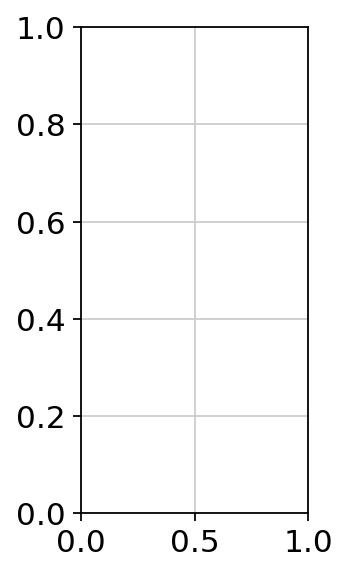

In [161]:
from matplotlib import pyplot as pl

idx = 0
pl.subplot(1, 2, idx + 1)

zip_result = zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  )

for label, color, mask in zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  ):
  print(f"{label}; {color}; {mask}")

In [162]:
for label, color, mask in zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
):
    if False:
        means_, var_or_disps_ = np.log10(means[mask]), np.log10(d[mask])
    else:
        means_, var_or_disps_ = means[mask], var_or_disp_norm[mask]
        print(means_, var_or_disp)

TNFRSF4    0.277410
CPSF3L     0.385194
ATAD3C     0.038252
C1orf86    0.678283
RER1       0.814813
             ...   
ICOSLG     0.082016
SUMO3      0.804815
SLC19A1    0.058960
S100B      0.286282
PRMT2      0.816647
Name: means, Length: 1838, dtype: float64 AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325459
RP11-206L10.9    0.859264
LINC00115        1.457477
                   ...   
AC145212.1       1.784637
AL592183.1       1.859941
AL354822.1       1.781924
PNRC2-1          1.567491
SRSF10-1         1.544864
Name: dispersions, Length: 13714, dtype: float64
AL627309.1       0.013556
AP006222.2       0.004696
RP11-206L10.2    0.005673
RP11-206L10.9    0.002644
LINC00115        0.027437
                   ...   
AC145212.1       0.027441
AL592183.1       0.485051
AL354822.1       0.012157
PNRC2-1          0.160366
SRSF10-1         0.100255
Name: means, Length: 11876, dtype: float64 AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325

总结一下，sc.pl.highly_variable_genes(adata)作图代码做的事，总共会作2个图。

第1个图，把adata中的每一个基因在所有细胞中的平均值，以及标准化的dispersion值取出来，以及哪些基因是highly variable gene的信息取出来，做散点图，每一个点代表一个基因，横坐标是基因的表达量的平均值，纵坐标是标准化的dispersion值，然后给是highly variable gene的点涂黑色，给不是highly variable gene的点涂灰色。

第2个图，只是把上面的标准化的dispersion值换成了没做标准化的dispersion值，其它的数据信息以及画图做法都一样。

##

引出的问题是，前面计算highly variable gene时，是怎么判断一个基因是否为highly variable gene的？dispersion值的标准化，是怎么做的？
需要看源代码。

##

到底是否需要做剔除高度变化的表达量的基因这种操作？我看晶能生物公司的分析报告中没有这个操作。

还有就是这个步骤有没有做剔除，还是只是把这些基因给找出来？

注意，不是剔除这些基因，而是只用这些基因做下游的分析！

https://www.embopress.org/doi/full/10.15252/msb.20188746

Current best practices in single-cell RNA-seq analysis: a tutorial

看一下这篇文献是怎么介绍的。

For example, barcodes with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane, and thus, only mRNA located in the mitochondria is still conserved.

死细胞，它们的细胞膜通透性增强，细胞质的mRNA会流失到细胞外，这样造成的结果是，检测到的一个细胞的总mRNA会很少，但是线粒体的mRNA仍然会留在线粒体内，所以能够被检测到，相对来说，线粒体的mRNA含量就会很高。

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

另一方面，如果在单细胞制备阶段，产生了doublet，即一个检测小孔中，掉入了2个细胞，那么检测到的总mRNA量会很高，但是这样的数据，就不是我们想要的单细胞的数据了。

所以在对count matrix的QC处理中，往往会把总mRNA count值很低的，或者是很高的，或者是线粒体mRNA比例值很高的细胞的数据给过滤掉。



##

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

差异检验，以及可视化基因表达量时，要用标准化和对数化的基因表达量数据。
这里我们把adata赋值给adata.raw。
后面可以拿到现在的原始的基因表达量的数值。

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [163]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

你如果不做sc.pp.regress_out和sc.pp.scale处理，那么你可以不用做adata.raw = adata的操作。

之前`sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)`函数计算检测到的高变化表达的基因的信息，保存在了adata.var.highly_variable，可以理解为是dataframe的一列内容，里面是基因是否为高变化表达基因的bool值。

高变化表达的基因的含义是什么？要把它们给剔除吗？

In [164]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

 
https://doi.org/10.15252/msb.20188746

 Feature selection

The first step of reducing the dimensionality of scRNA-seq datasets commonly is feature selection. In this step, the dataset is filtered to keep only genes that are “informative” of the variability in the data. Thus, highly variable genes (HVGs) are often used (Brennecke et al, 2013). Depending on the task and the complexity of the dataset, typically between 1,000 and 5,000 HVGs are selected for downstream analysis (see Fig EV1 and Dataset EV1). Preliminary results from Klein et al (2015) suggest that downstream analysis is robust to the exact choice of the number of HVGs. While varying the number of HVGs between 200 and 2,400, the authors reported similar low-dimensional representations in the PCA space. Based on this result, we prefer to err on the side of higher numbers of HVGs.

highly variable genes (HVGs)高变化表达基因，不是要把它们剔除，而是要选它们做下游的分析，而舍弃其它那些在细胞间没什么差异的基因，这样在降维分析中，能减少计算量而又不会对降维聚类结果造成很大的偏差。

In [165]:
type(adata.var.highly_variable)

pandas.core.series.Series

下面需要先看一下2018年那篇最佳实践的文献

https://www.embopress.org/doi/full/10.15252/msb.20188746

### 做实际数据过滤操作

Actually do the filtering

#### （1）只保留表达量高度变化的基因数据列

过滤表达量矩阵，
每一行代表一个细胞，每一列代表一种基因，
只保留表达量高度变化的基因的列。

In [166]:
adata = adata[:, adata.var.highly_variable]

####（2）剔除异常细胞数据行

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

作回归曲线，然后对某一个细胞的总表达量，以及线粒体基因表达量比例，这两方面异常的细胞，剔除这样的细胞的数据。

用的是简单的线性回归。

In [167]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:06)


#### （3）缩放变换

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

对数据做缩放变换，使数据的方差值为1，平均值为0。这是最终的效果。

In [168]:
sc.pp.scale(adata, max_value=10)

In [169]:
## @singledispatch
def scale(
    # X: Union[AnnData, spmatrix, np.ndarray],
    # zero_center: bool = True,
    # max_value: Optional[float] = None,
    # copy: bool = False,
    # layer: Optional[str] = None,
    # obsm: Optional[str] = None,
    # 
    X,
    zero_center = True,
    max_value = None,
    copy = False,
    layer = None,
    obsm = None,
):
    """\
    Scale data to unit variance and zero mean.

    .. note::
        Variables (genes) that do not display any variation (are constant across
        all observations) are retained and (for zero_center==True) set to 0
        during this operation. In the future, they might be set to NaNs.

    Parameters
    ----------
    X
        The (annotated) data matrix of shape `n_obs` × `n_vars`.
        Rows correspond to cells and columns to genes.
    zero_center
        If `False`, omit zero-centering variables, which allows to handle sparse
        input efficiently.
    max_value
        Clip (truncate) to this value after scaling. If `None`, do not clip.
    copy
        Whether this function should be performed inplace. If an AnnData object
        is passed, this also determines if a copy is returned.
    layer
        If provided, which element of layers to scale.
    obsm
        If provided, which element of obsm to scale.

    Returns
    -------
    Depending on `copy` returns or updates `adata` with a scaled `adata.X`,
    annotated with `'mean'` and `'std'` in `adata.var`.
    """
    _check_array_function_arguments(layer=layer, obsm=obsm)
    if layer is not None:
        raise ValueError(f"`layer` argument inappropriate for value of type {type(X)}")
    if obsm is not None:
        raise ValueError(f"`obsm` argument inappropriate for value of type {type(X)}")
    return scale_array(X, zero_center=zero_center, max_value=max_value, copy=copy)


## @scale.register(np.ndarray)
def scale_array(
    # X,
    # *,
    # zero_center: bool = True,
    # max_value: Optional[float] = None,
    # copy: bool = False,
    # return_mean_std: bool = False,
    # 
    X,
    *,
    zero_center = True,
    max_value = None,
    copy = False,
    return_mean_std = False,
):
    if copy:
        X = X.copy()
    if not zero_center and max_value is not None:
        logg.info(  # Be careful of what? This should be more specific
            "... be careful when using `max_value` " "without `zero_center`."
        )

    if np.issubdtype(X.dtype, np.integer):
        logg.info(
            '... as scaling leads to float results, integer '
            'input is cast to float, returning copy.'
        )
        X = X.astype(float)

    mean, var = _get_mean_var(X)
    std = np.sqrt(var)
    std[std == 0] = 1
    if issparse(X):
        if zero_center:
            raise ValueError("Cannot zero-center sparse matrix.")
        sparsefuncs.inplace_column_scale(X, 1 / std)
    else:
        if zero_center:
            X -= mean
        X /= std

    # do the clipping
    if max_value is not None:
        logg.debug(f"... clipping at max_value {max_value}")
        X[X > max_value] = max_value

    if return_mean_std:
        return X, mean, std
    else:
        return X

### sc.pp.scale()缩放变换函数小结

把一种基因的在某一个细胞中的表达量值，减去在所有细胞中表达量的平均值，然后除以在所有细胞中表达量的标准差，得到的值的含义是，这一种基因在这一个细胞中的表达量是正或负的多少倍标准差，这一种基因的这些值在不同的细胞中是可以比较大小的。如果这个值比10大，那么会强制把这个值改写为10。

#

我发现源代码有个bug，默认是做zero-center的，也就是会出现正数和负数，但是做max_value限制时，只对正数大于10的值强制改写为10，而对小于-10的值是没有任何改写措施的。

这需要作者改进一下源代码。

20211114 从这开始学习

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [170]:
# scanpy.tools tl表示tools
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

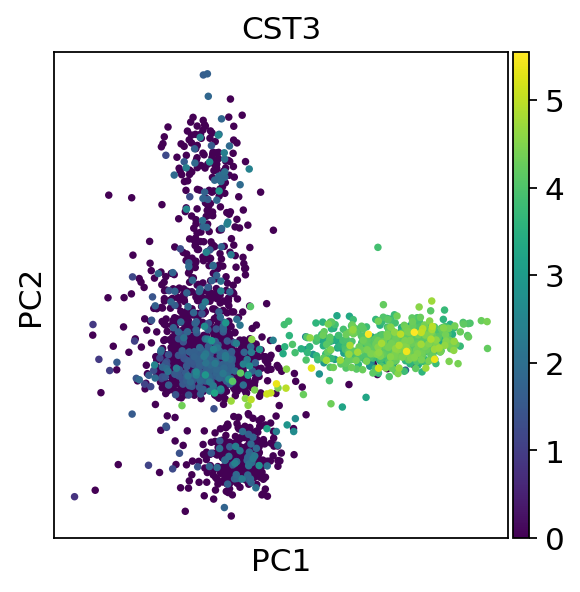

In [171]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

### 查看adata对象的PCA分析的结果信息

In [172]:
adata.uns  
#   variance_ratio

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([32.110428 , 18.718653 , 15.607338 , 13.235298 ,  4.8022676,
        3.9859312,  3.5262313,  3.2334378,  3.1212087,  3.075262 ,
        2.998079 ,  2.959516 ,  2.9517858,  2.944246 ,  2.9138749,
        2.8990324,  2.8806794,  2.8646843,  2.843064 ,  2.835752 ,
        2.8314204,  2.8182364,  2.803552 ,  2.799986 ,  2.788956 ,
        2.7781026,  2.7705767,  2.7602205,  2.753861 ,  2.7459562,
        2.7371857,  2.7341259,  2.7222016,  2.712309 ,  2.7024777,
        2.700048 ,  2.683853 ,  2.6790519,  2.6769092,  2.6739955,
        2.6648524,  2.6573112,  2.6511767,  2.6417766,  2.6329713,
        2.6295202,  2.6245303,  2.6183765,  2.6180038,  2.6018658],
      dtype=float32), 'variance_ratio': array([0.02012817, 0.01173364, 0.00978334, 0.00829645, 0.00301026,
       0.00249855, 0.00221039, 0.00202686

In [173]:
adata.uns['pca']

{'params': {'use_highly_variable': True, 'zero_center': True},
 'variance': array([32.110428 , 18.718653 , 15.607338 , 13.235298 ,  4.8022676,
         3.9859312,  3.5262313,  3.2334378,  3.1212087,  3.075262 ,
         2.998079 ,  2.959516 ,  2.9517858,  2.944246 ,  2.9138749,
         2.8990324,  2.8806794,  2.8646843,  2.843064 ,  2.835752 ,
         2.8314204,  2.8182364,  2.803552 ,  2.799986 ,  2.788956 ,
         2.7781026,  2.7705767,  2.7602205,  2.753861 ,  2.7459562,
         2.7371857,  2.7341259,  2.7222016,  2.712309 ,  2.7024777,
         2.700048 ,  2.683853 ,  2.6790519,  2.6769092,  2.6739955,
         2.6648524,  2.6573112,  2.6511767,  2.6417766,  2.6329713,
         2.6295202,  2.6245303,  2.6183765,  2.6180038,  2.6018658],
       dtype=float32),
 'variance_ratio': array([0.02012817, 0.01173364, 0.00978334, 0.00829645, 0.00301026,
        0.00249855, 0.00221039, 0.00202686, 0.00195651, 0.0019277 ,
        0.00187932, 0.00185515, 0.0018503 , 0.00184558, 0.00182654,

In [174]:
adata.uns['pca']['variance_ratio']

array([0.02012817, 0.01173364, 0.00978334, 0.00829645, 0.00301026,
       0.00249855, 0.00221039, 0.00202686, 0.00195651, 0.0019277 ,
       0.00187932, 0.00185515, 0.0018503 , 0.00184558, 0.00182654,
       0.00181724, 0.00180573, 0.00179571, 0.00178215, 0.00177757,
       0.00177485, 0.00176659, 0.00175738, 0.00175515, 0.00174824,
       0.00174143, 0.00173671, 0.00173022, 0.00172624, 0.00172128,
       0.00171578, 0.00171387, 0.00170639, 0.00170019, 0.00169403,
       0.0016925 , 0.00168235, 0.00167934, 0.001678  , 0.00167617,
       0.00167044, 0.00166572, 0.00166187, 0.00165598, 0.00165046,
       0.00164829, 0.00164517, 0.00164131, 0.00164108, 0.00163096],
      dtype=float32)

In [175]:
print("np.log(0.02012817) =",np.log(0.02012817))
print("np.log(0.01173364) =",np.log(0.01173364))

np.log(0.02012817) = -3.905634952553828
np.log(0.01173364) = -4.445295349024108


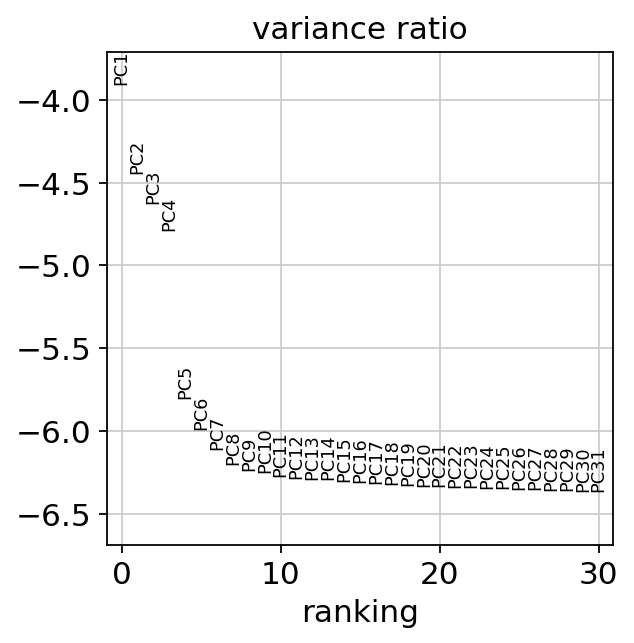

In [172]:
sc.pl.pca_variance_ratio(adata, log=True)
# 这里的图中纵坐标是取对数之后的值，
# 比如原来PC1的贡献是2%，即0.02，然后取自然对数，得-3.9。
# 用对数值来展示是因为，原来的数据是小数，例如0.02，不好看，占的位数太多，里面的很多个0其实没有实际的信息，
# 取对数后，变成绝对值大于1的数，能很容易看出数据的主要信息。

Save the result.

In [176]:
print('results_file:', results_file)

results_file: write/pbmc3k.h5ad


In [177]:
adata.write(results_file)
# 生成h5ad格式的文件

In [178]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

我有种感觉是，用PCA分析得到的降维后的各个PC的数据，来做下游的细胞聚类分簇分析。

即做细胞聚类分簇分析时，用的不是细胞-基因表达量矩阵。?

## Computing the neighborhood graph

neighborhood: 附近区域

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

[知乎上关于数学概念manifold的介绍](https://zhuanlan.zhihu.com/p/44066392#:~:text=%20%E6%89%80%E8%B0%93%E6%B5%81%E5%BD%A2%EF%BC%88manifold%EF%BC%89%E5%B0%B1%E6%98%AF%E4%B8%80%E8%88%AC%E7%9A%84%E5%87%A0%E4%BD%95%E5%AF%B9%E8%B1%A1%E7%9A%84%E6%80%BB%E7%A7%B0%E3%80%82,%E6%AF%94%E5%A6%82%E4%BA%BA%EF%BC%8C%E6%9C%89%E4%B8%AD%E5%9B%BD%E4%BA%BA%E3%80%81%E7%BE%8E%E5%9B%BD%E4%BA%BA%E7%AD%89%E7%AD%89%EF%BC%9B%E6%B5%81%E5%BD%A2%E5%B0%B1%E5%8C%85%E6%8B%AC%E5%90%84%E7%A7%8D%E7%BB%B4%E6%95%B0%E7%9A%84%E6%9B%B2%E7%BA%BF%E6%9B%B2%E9%9D%A2%E7%AD%89%E3%80%82%20%E5%92%8C%E4%B8%80%E8%88%AC%E7%9A%84%E9%99%8D%E7%BB%B4%E5%88%86%E6%9E%90%E4%B8%80%E6%A0%B7%EF%BC%8C%E6%B5%81%E5%BD%A2%E5%AD%A6%E4%B9%A0%E6%8A%8A%E4%B8%80%E7%BB%84%E5%9C%A8%E9%AB%98%E7%BB%B4%E7%A9%BA%E9%97%B4%E4%B8%AD%E7%9A%84%E6%95%B0%E6%8D%AE%E5%9C%A8%E4%BD%8E%E7%BB%B4%E7%A9%BA%E9%97%B4%E4%B8%AD%E9%87%8D%E6%96%B0%E8%A1%A8%E7%A4%BA%E3%80%82)

manifold的中文翻译有“流形”、“多面体”，我的粗略理解是，它是高维度空间中的几何体的统称，包括各种维数的曲线曲面。

一般提到manifold的时候，往往会做降维操作，也就是把多维度的数据，降维成只有少数几个维度的数据。

In [179]:
# scanpy.preprocessing
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Compute a neighborhood graph of observations 
# 就是计算细胞点的邻近区域的图的情况。
# 内部计算有点复杂，我可以先看后面的作图然后再回来理解这里的计算。

computing neighbors
    using 'X_pca' with n_pcs = 40


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

什么叫“embed”，

global connectivity of the manifold

preserve trajectories

使用UMAP降维方法，把数据降维至只有2维。

Embed the neighborhood graph using UMAP.

UMAP (Uniform Manifold Approximation and Projection) is a manifold learning
    technique suitable for visualizing high-dimensional data.

In [180]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


CST3是一个基因的名字
https://uswest.ensembl.org/Multi/Search/Results?q=CST3

NKG7是一个基因的名字
https://uswest.ensembl.org/Multi/Search/Results?q=NKG7

PPBP是一个基因的名字
https://uswest.ensembl.org/Multi/Search/Results?q=PPBP

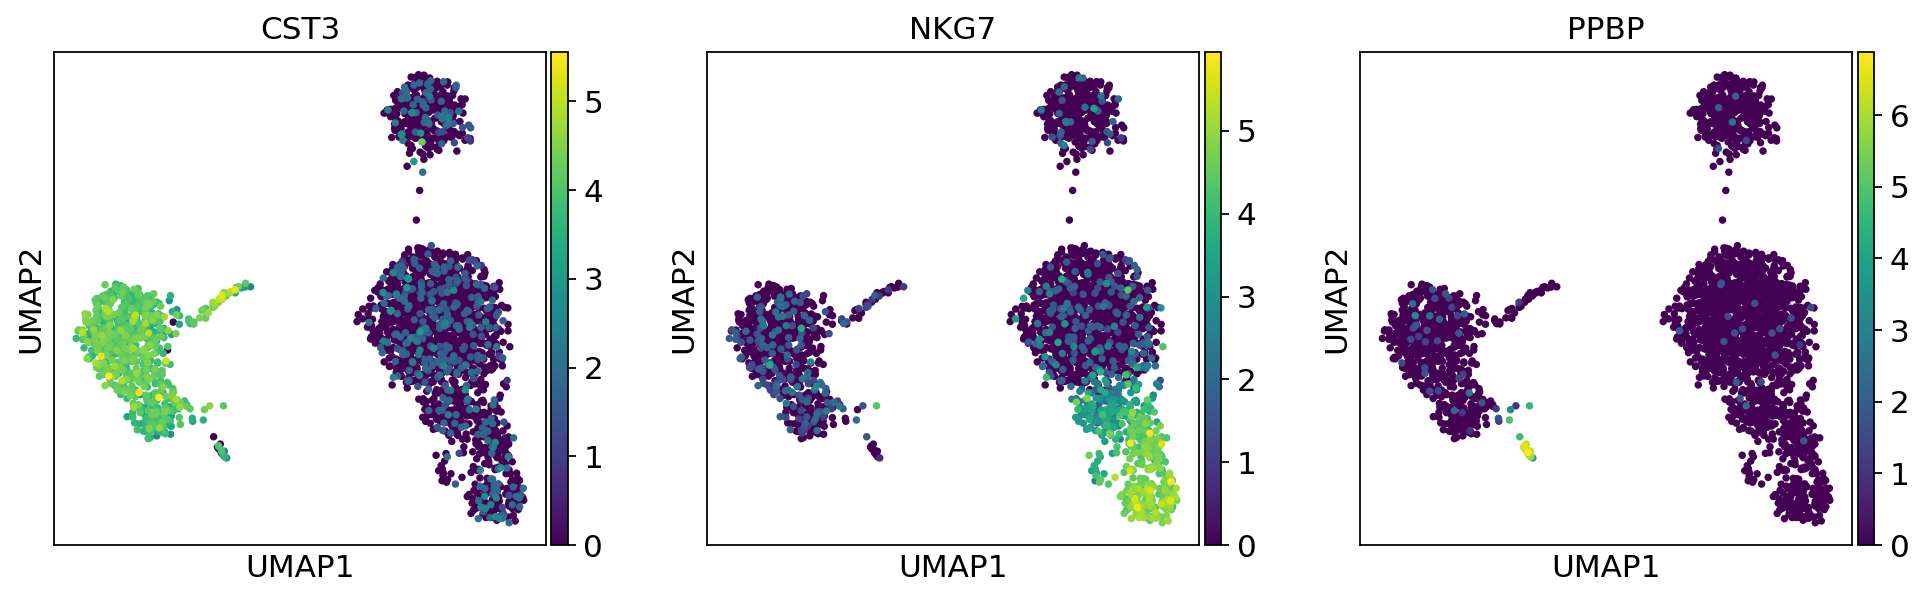

In [181]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
# Scatter plot in UMAP basis.
# Plot muliple umaps for different gene expressions.
# 画多个图，对每一个图中的细胞点涂色，根据某1种基因的表达量数值的大小来涂色。
# 这用的是原始的表达量（只做了标准化，对数化，没做校正）来涂色的。

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

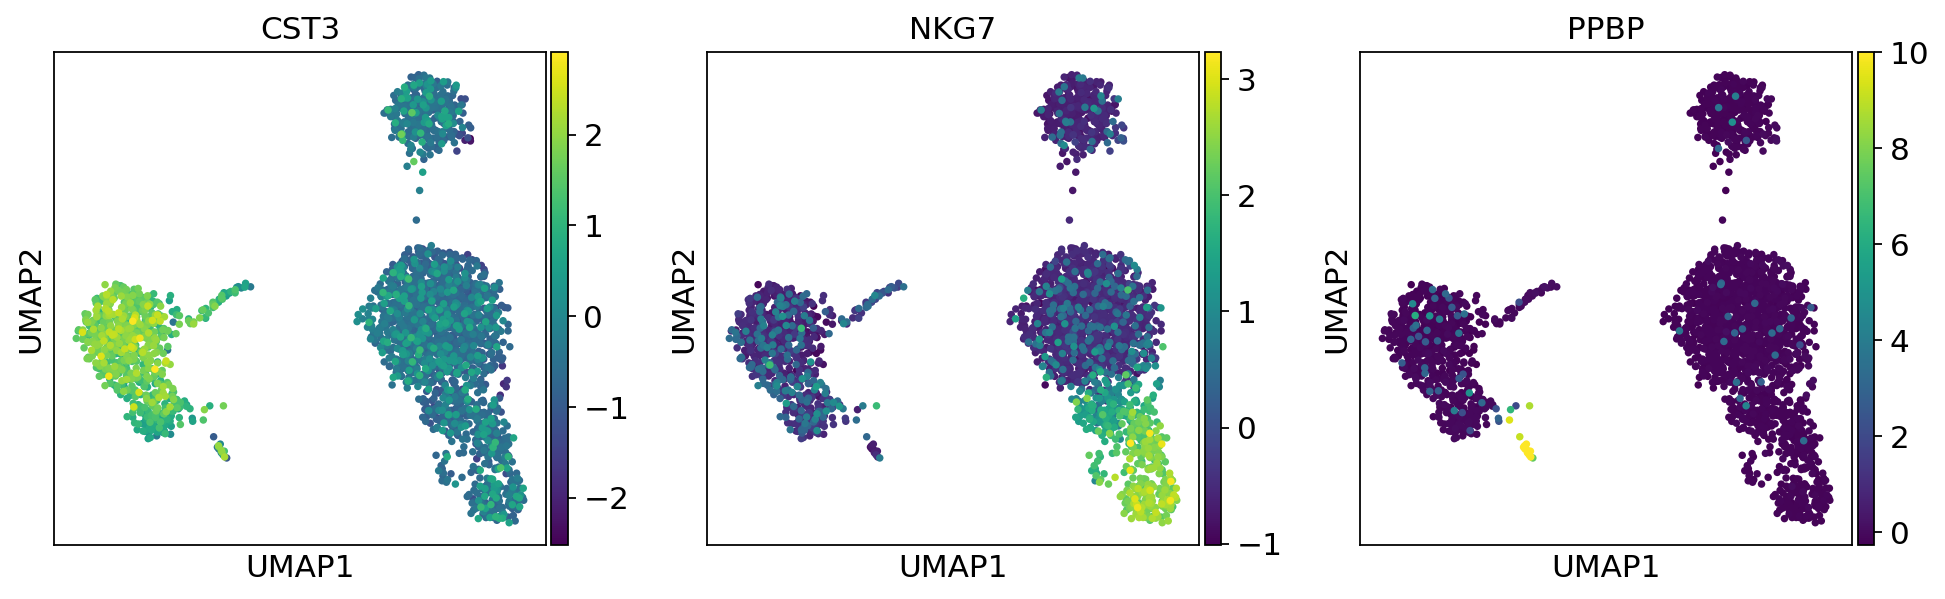

In [182]:
# 参数use_raw=False，表示不用原始的表达量数值来涂色，而是用校正后的表达量数值来涂色。
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

## 聚类邻近区域的graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [184]:
# 需要安装leidenalg包
!pip3 install leidenalg

     |████████████████████████████████| 1.4 MB 12.2 MB/s 
     |████████████████████████████████| 3.2 MB 83.6 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9070 sha256=c6da92db04f284e32c3c071b06b2b625594fd45281cf5897c615e5099df47ec4
  Stored in directory: /root/.cache/pip/wheels/15/86/ef/b8bcdfbcb1c489771ad256c7cd1eb4971cdb7f3f670938b798
Successfully built python-igraph


In [185]:
sc.tl.leiden(adata)
# 把细胞聚类成不同的簇，用的是Leiden算法，它是Louvain算法的改良版本。
# Cluster cells into subgroups
# Cluster cells using the Leiden algorithm [Traag18]_,
# an improved version of the Louvain algorithm [Blondel08]_.
# It has been proposed for single-cell analysis by [Levine15]_.

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

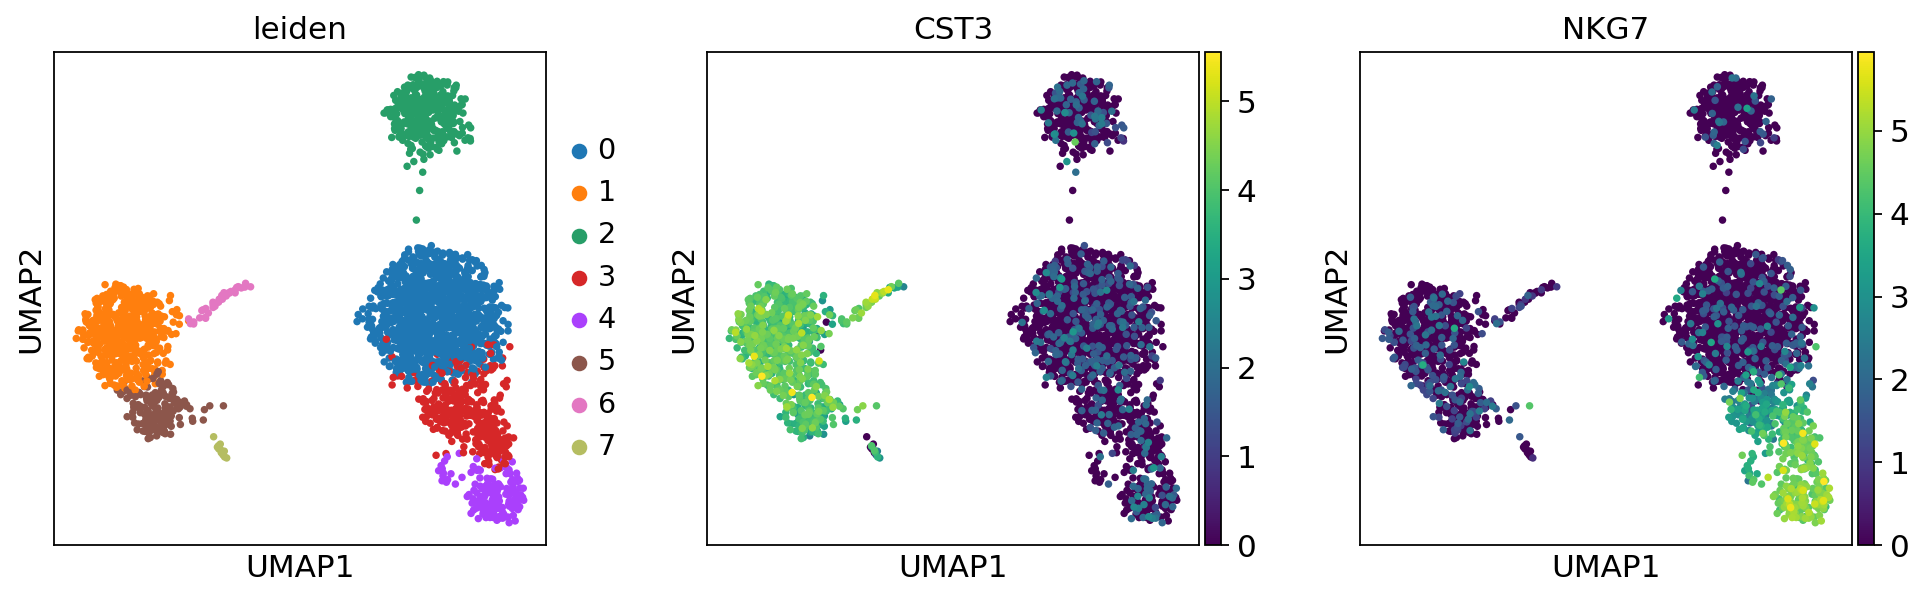

In [186]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
# 作图函数中的color参数值中，还可以写'leiden'，
# 这样作出来的图中，就会给细胞点按照leiden算法分出来的不同的细胞簇涂各自的颜色。

Save the result.

In [187]:
adata.write(results_file)

## Finding marker genes

## 找marker标志基因

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

In [188]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
# 对每一个细胞簇内部的高度差异的基因作排序
# groupby='leiden'，表示，以'leiden'算法分出来的细胞簇，来每一个细胞簇内部的基因排序

# 期望接收的数值是对数化的数值

# 我不明白如何用t-test对高度差异的基因做排序？


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


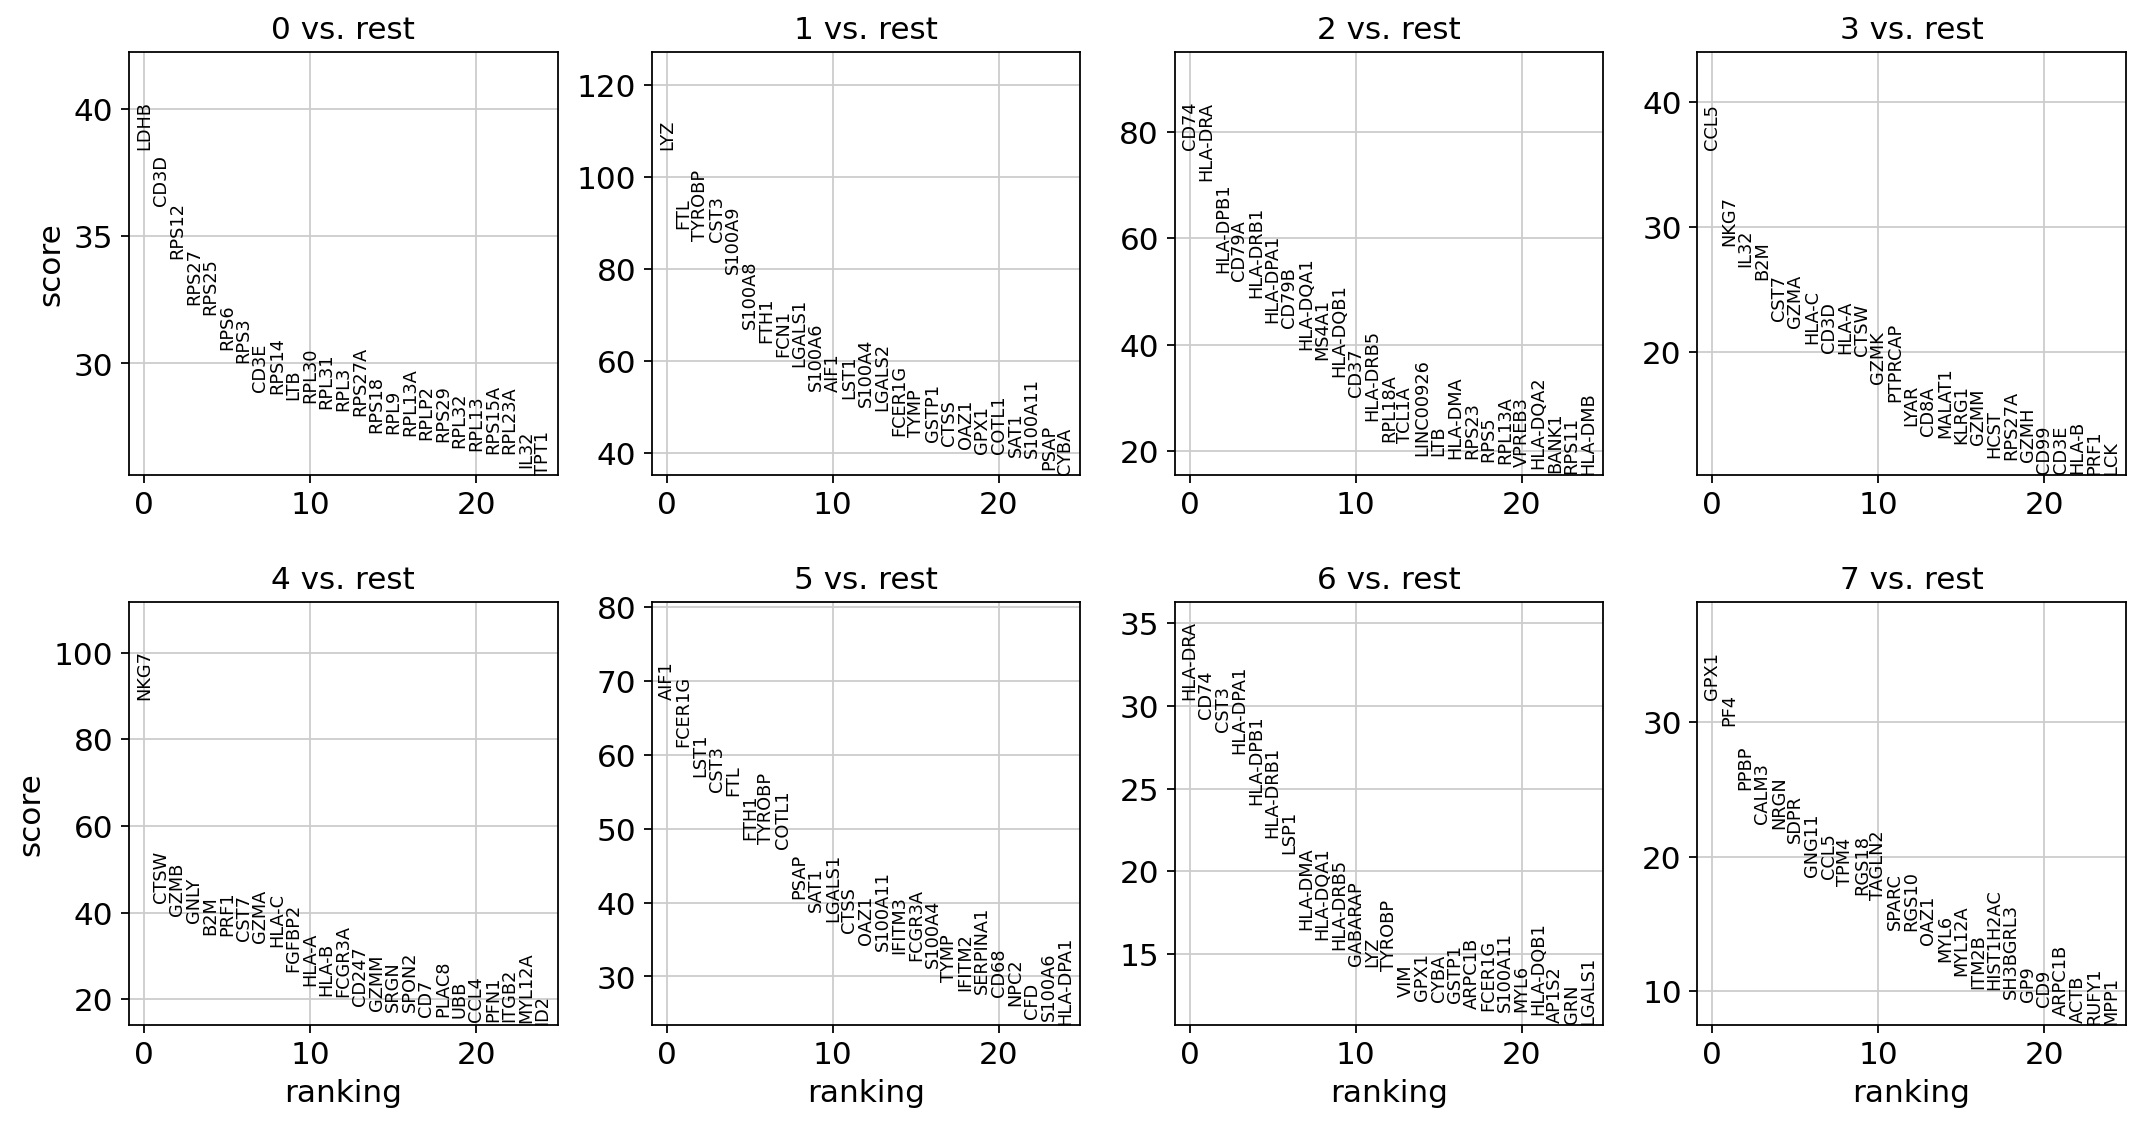

In [189]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
# sharey
#     Controls if the y-axis of each panels should be shared. But passing
#     `sharey=False`, each panel has its own y-axis range.
# sharey参数，含义为share y，即是否共享y轴，如果是，则每一个图的y轴的范围是一样的。

# 从作图结果看，我感觉之前的sc.tl.rank_genes_groups()函数的做法是，
# 例如图1，第0簇的细胞中的某一种基因的平均表达量与其它第1簇到第7簇细胞的这一种基因的平均表达量，做t-test看是否有显著差异，
# 差异的大小用score值来衡量，比如可能跟p值有关，跟表达量倍数有关，即p值越小、表达量倍数越大的基因，则score值越大，差异越显著。
# 我的想法待验证？

In [190]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

肯定是用rank-sum秩和检验更加严谨，因为rank-sum秩和检验，适用于总体不是正态分布的检验，而t-test只适用于正态分布的总体。

到底能不能用组织样本RNAseq的DESeq2方法来找这里的细胞簇之间的差异基因？

如果用DESeq2来理解找差异基因的过程，就非常好理解前面在做什么了。

把第0簇细胞当做是实验组，每一个细胞就是一个传统组织样本，把第1簇至第7簇细胞混在一起，当做是对照组，里面的每一个细胞就是一个传统组织样本，目的就是找实验组与对照组之间的显著差异表达基因。

ranking genes
    finished (0:00:01)


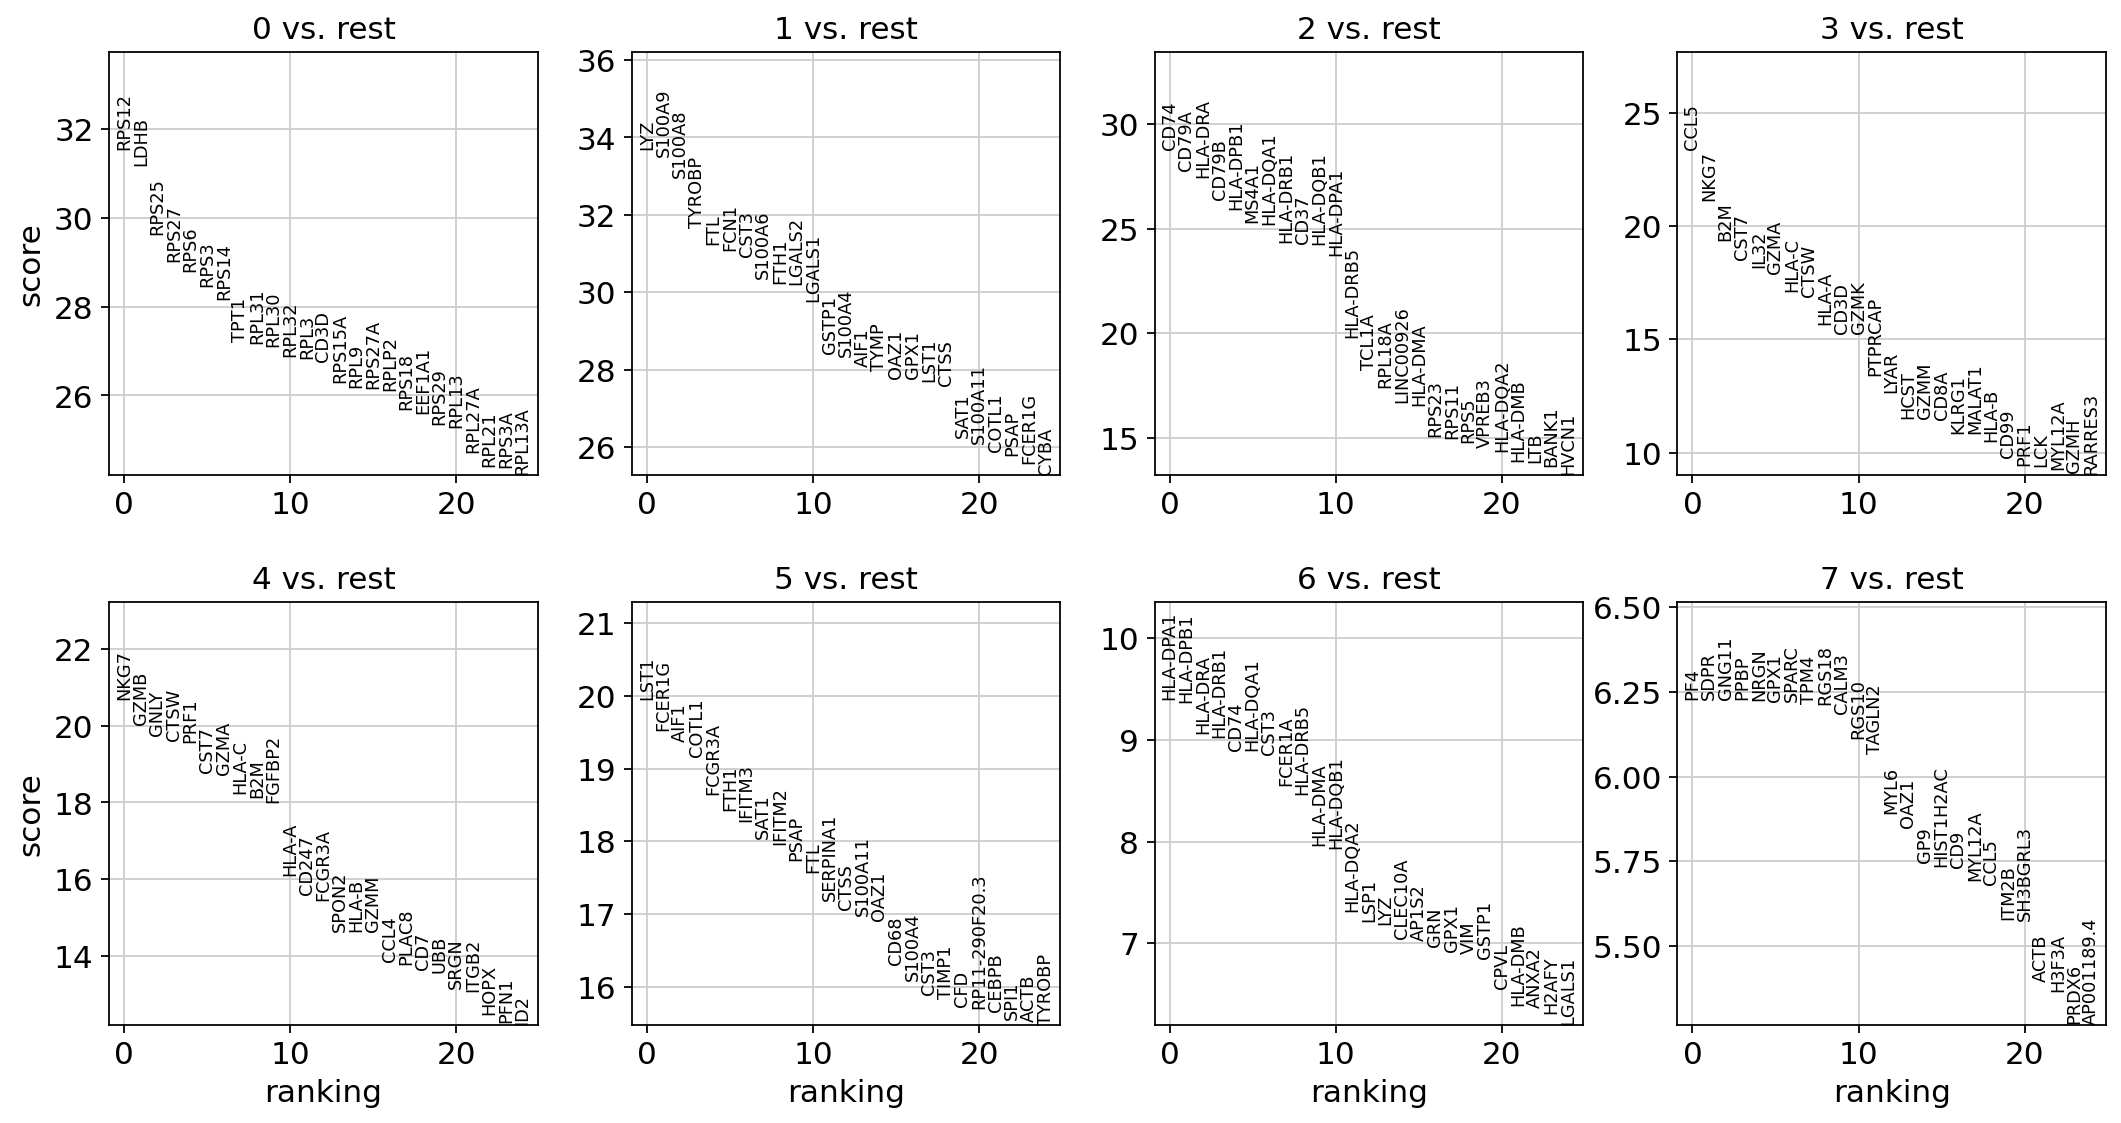

In [191]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [192]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

 logistic regression？

ranking genes
    finished (0:00:09)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


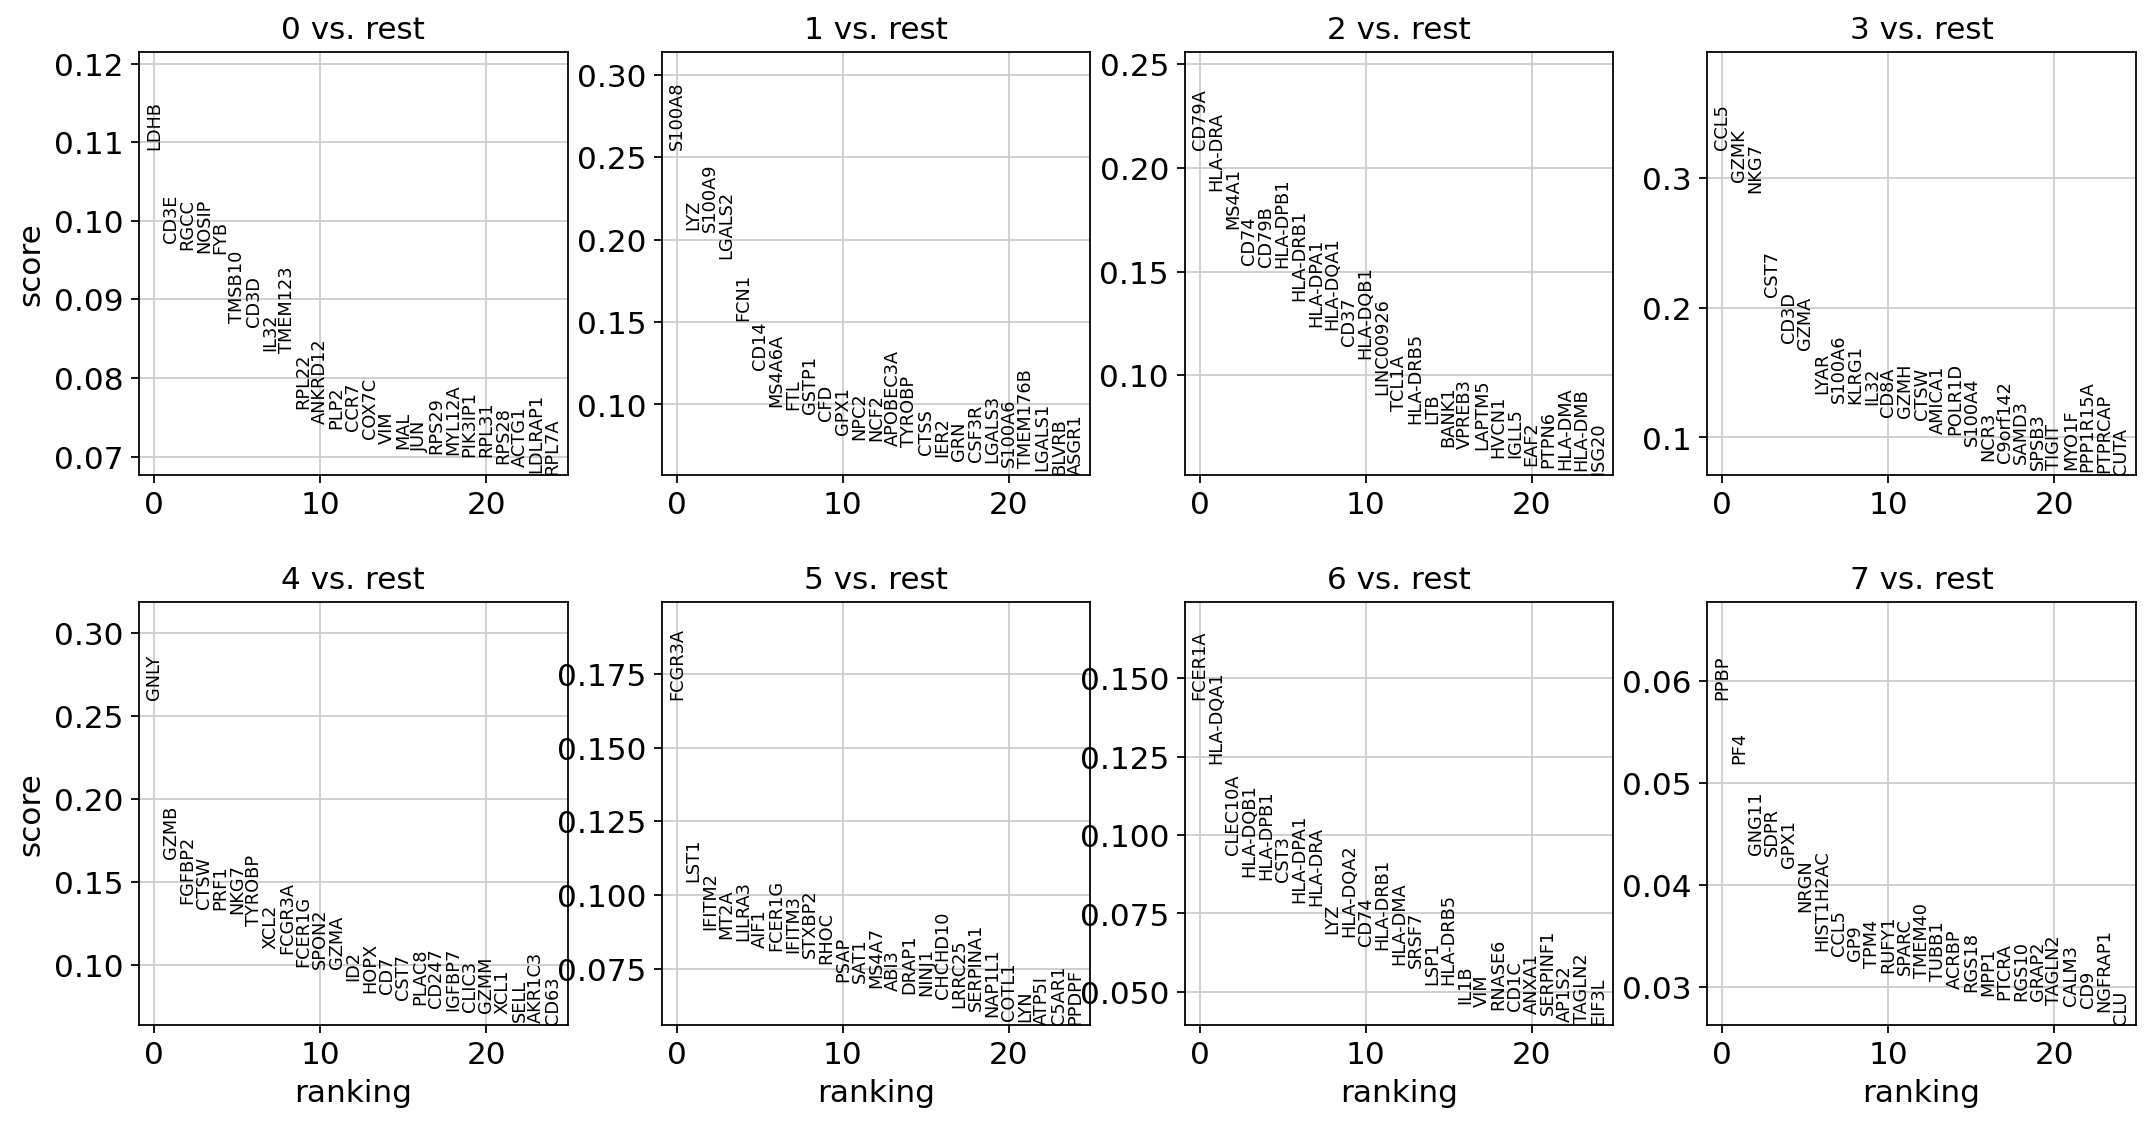

In [193]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

外周血单核细胞的Cell Type的Markers基因信息，应该是通过前人的文献总结出来的，不是在这里分析出来的。

Let us also define a list of marker genes for later reference.

In [194]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [195]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [196]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GZMB  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GNLY    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  IL32  PRF1  FCGR3A      CD74   NRGN

Get a table with the scores and groups.

In [197]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  ...           6_p    7_n           7_p
0  RPS12  1.877956e-218     LYZ  ...  5.422417e-21    PF4  4.722886e-10
1   LDHB  1.782734e-213  S100A9  ...  7.591860e-21   SDPR  4.733899e-10
2  RPS25  5.870126e-193  S100A8  ...  1.306768e-19  GNG11  4.733899e-10
3  RPS27  3.927448e-185  TYROBP  ...  1.865104e-19   PPBP  4.744938e-10
4   RPS6  3.232888e-182     FTL  ...  5.853161e-19   NRGN  4.800511e-10

[5 rows x 16 columns]

Compare to a single cluster: 

ranking genes
    finished (0:00:00)


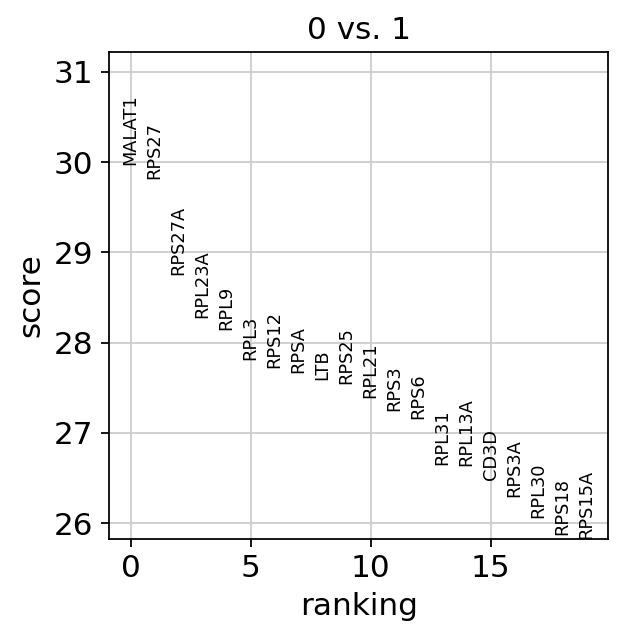

In [198]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

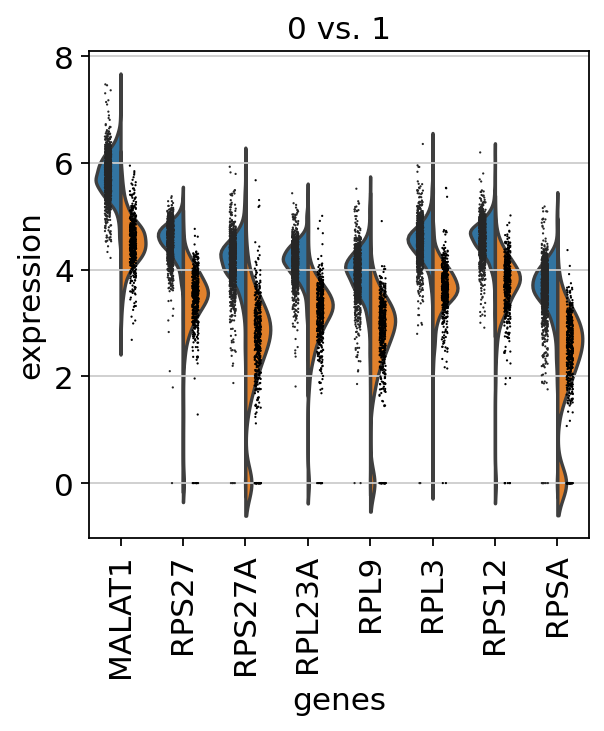

In [199]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
# 我对这个图的理解是，只看其中一种基因，
# 里面左侧是第0簇细胞的所有细胞的这种基因的表达量数据点，
# 右侧是第1簇细胞的所有细胞的这种基因的表达量数据点。

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [200]:
adata = sc.read(results_file)

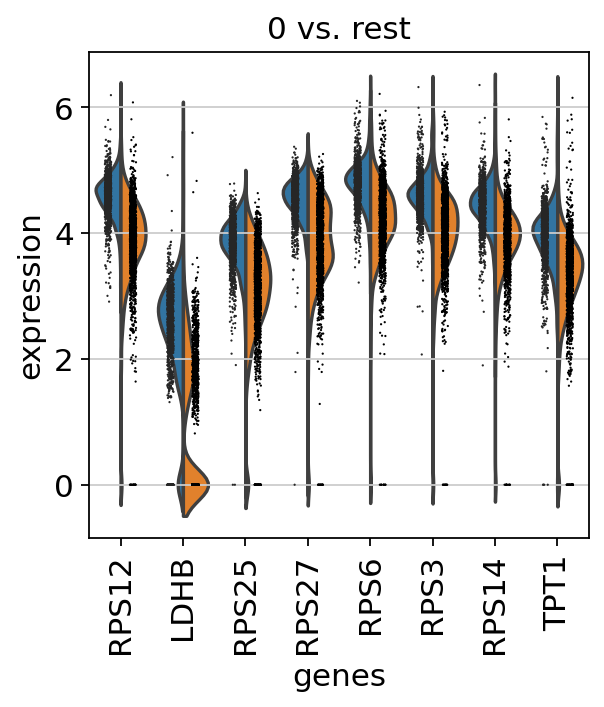

In [201]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
# 表达量值怎么还有比0小的呢？

### 在所有的簇的细胞中，看某一种基因的表达量数据点的分布

If you want to compare a certain gene across groups, use the following.

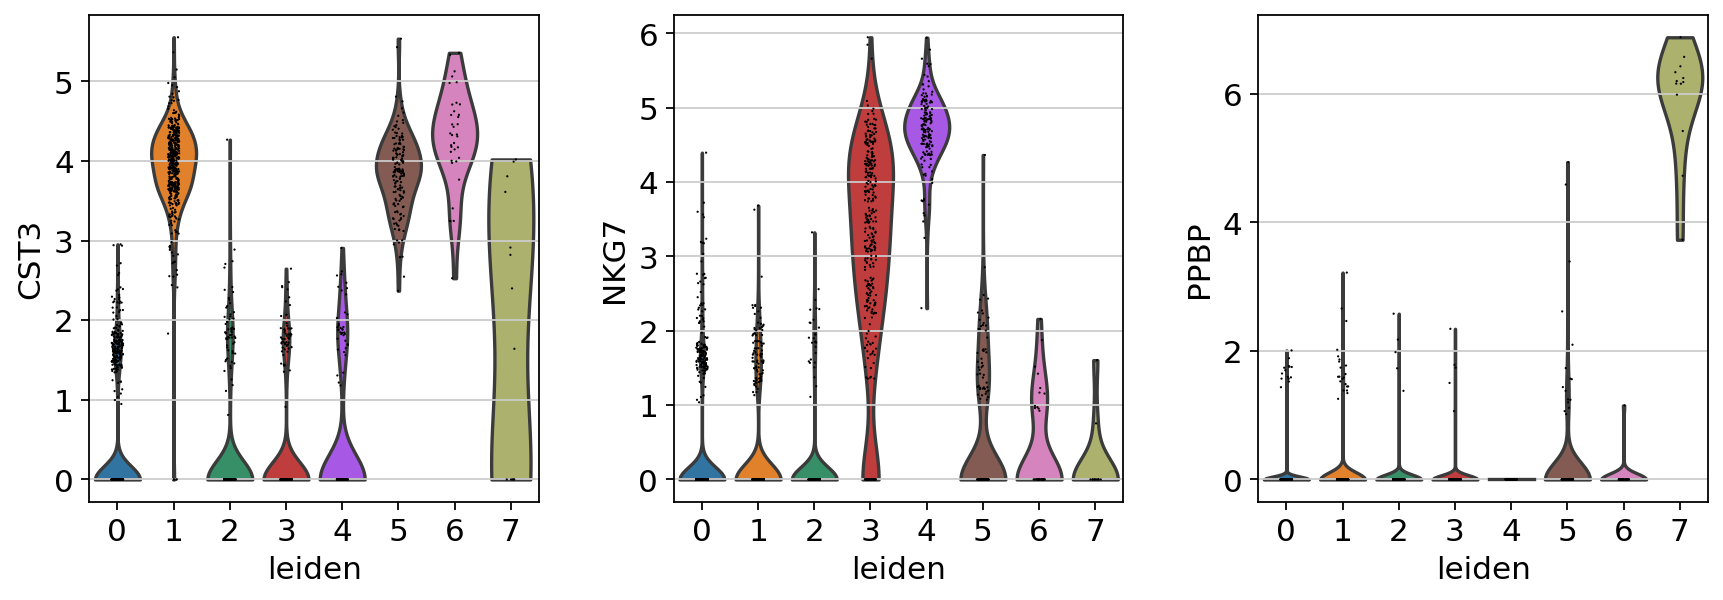

In [202]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [203]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
# 这个代码只是把0,1,2,3,4,5,6,7改名为'CD4 T', 'CD14 Monocytes',
# 'B', 'CD8 T', 
# 'NK', 'FCGR3A Monocytes',
# 'Dendritic', 'Megakaryocytes'

# 但是它怎么判定第0簇细胞就是'CD4 T'细胞？

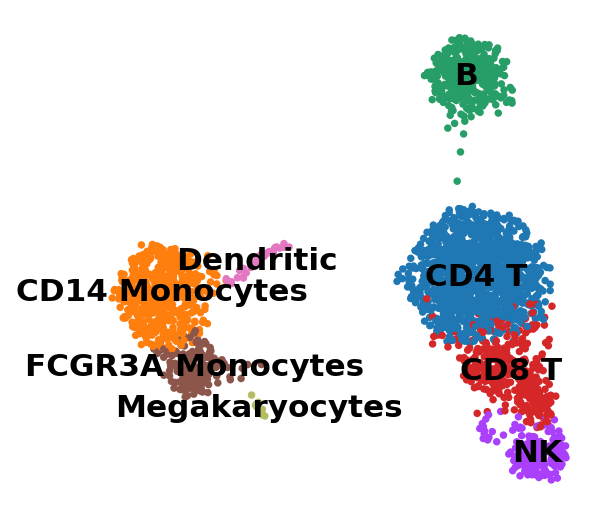

In [204]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

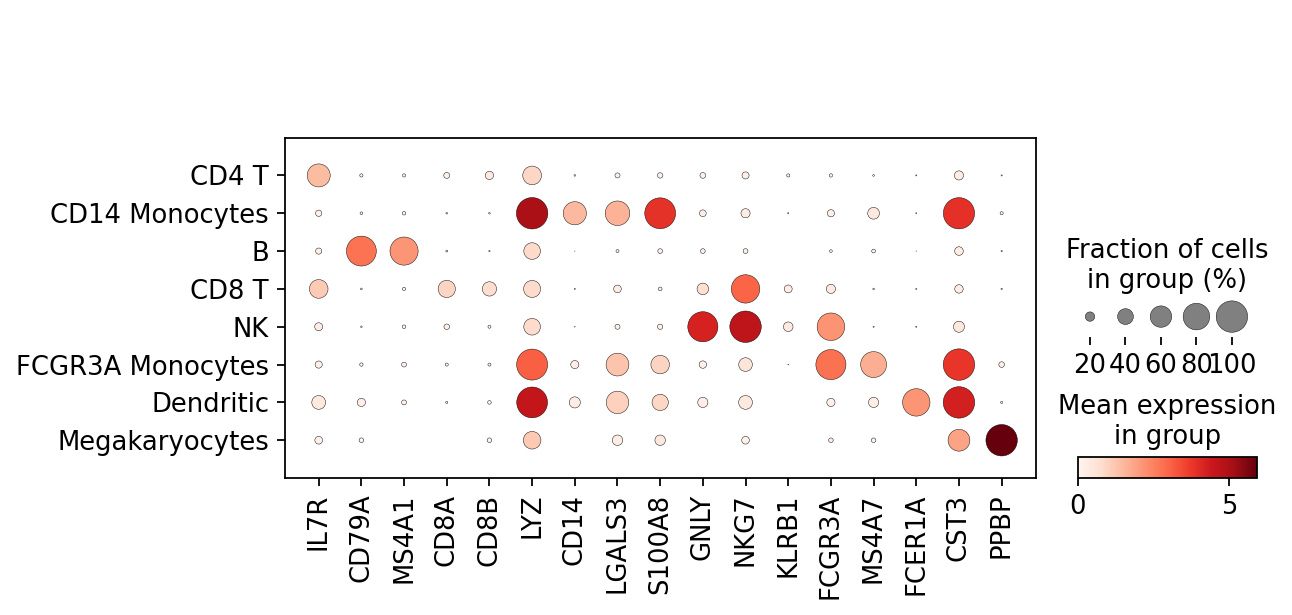

In [205]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

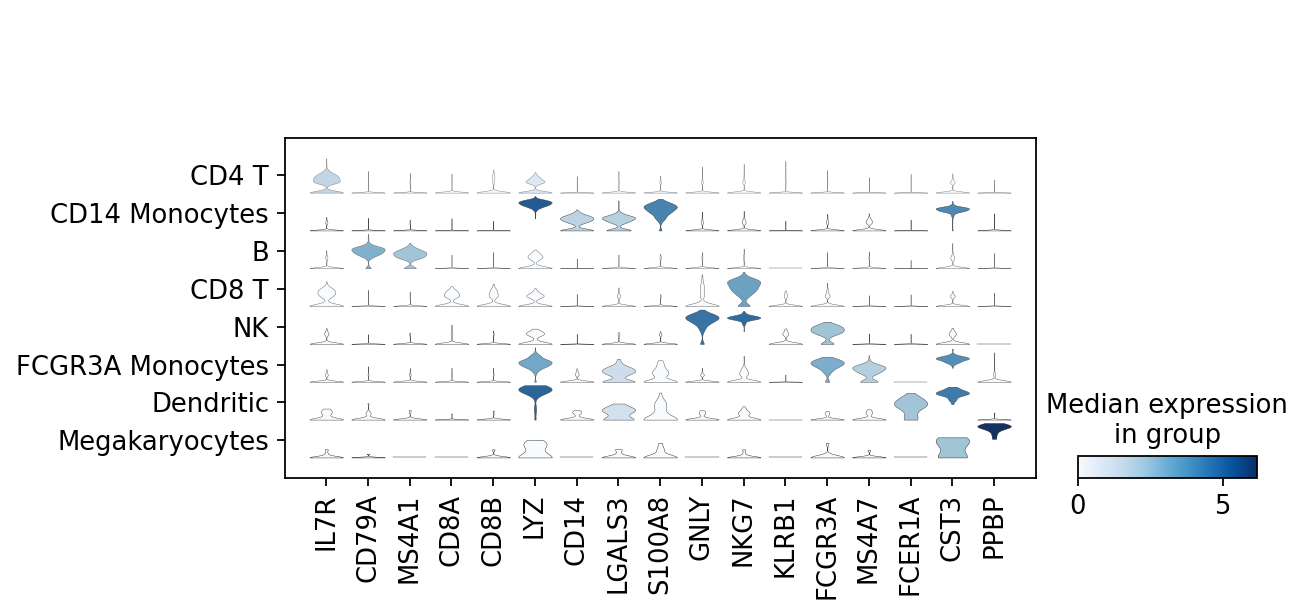

In [206]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [207]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [208]:
adata.write(results_file, compression='gzip')  
# `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [209]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

我试一下自己起一些细胞类型的名字

In [210]:
new_cluster_names = [
    'A', 'B',
    'C', 'D', 
    'E', 'F',
    'G', 'H']
adata.rename_categories('leiden', new_cluster_names)

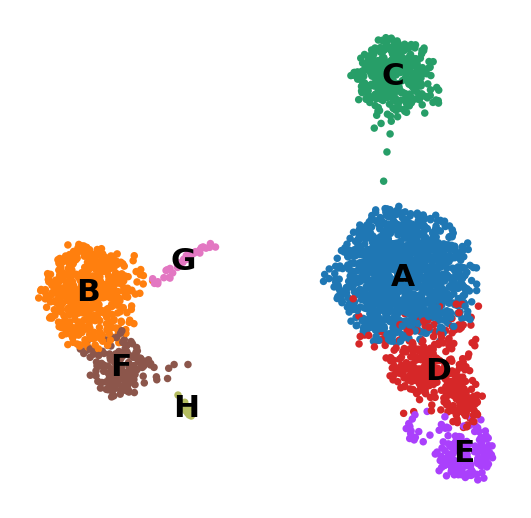

In [211]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

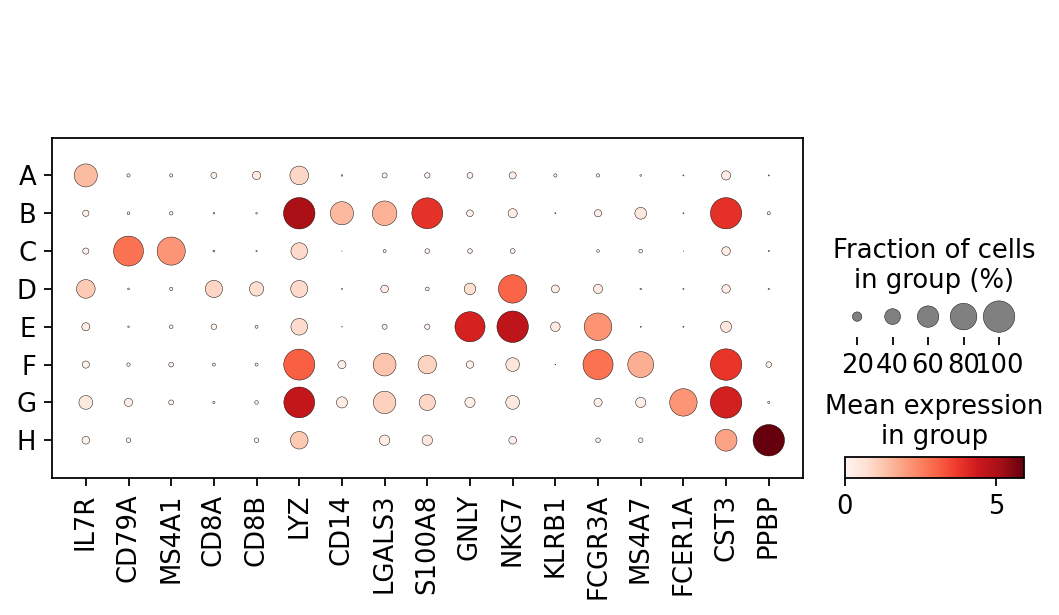

In [212]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

我感觉给leiden算法中分出来的细胞簇做cell type的命名工作，应该是，
先有通过前人文献总结的每一种cell type各自明显高表达的Marker基因的信息表格；
然后用sc.pl.dotplot()函数作图，或者是定位出这些Marker基因在本次数据分析分出来的细胞簇中，在哪一个细胞簇中的表达量是最高的，然后把这一个细胞簇命名为对应的cell type。

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

在写adata.rename_categories('leiden', new_cluster_names)中的参数new_cluster_names list时，应该是对照着sc.pl.dotplot(adata, marker_genes, groupby='leiden')的作图结果来写的。

我接下来的一个学习关注点是，如何对分簇的细胞簇做cell type的注释？


https://www.embopress.org/doi/full/10.15252/msb.20188746

While it may be tempting to assume that the clusters detected in single-cell data represent cell types, there are several axes of variation that determine cellular identity (Wagner et al, 2016; Clevers et al, 2017). Firstly, it is not always clear what constitutes a cell type. For example, while “T cells” may be a satisfactory label of a cell type to some, others may look for T-cell subtypes within a dataset and distinguish between CD4+ and CD8+ T cells (Wagner et al, 2016; Clevers et al, 2017). Furthermore, cells of the same cell type in different states may be detected in separate clusters. For the above reasons, it is best to use the term “cell identities” rather than “cell types”. Before clustering and annotating clusters, the user must decide which level of annotation detail, and thus which cluster resolution, is of interest.

There are two ways to use reference database information to annotate clusters: using data-derived marker genes or using full gene expression profiles. Marker gene sets can be found by applying differential expression (DE) testing between two groups: the cells in one cluster and all other cells in the dataset (see “Differential expression testing”). Typically, we focus on genes that are up-regulated in the cluster of interest. As marker genes are expected to have strong differential expression effects, simple statistical tests such as the Wilcoxon rank-sum test or the t-test are often used to rank genes by their difference in expression between these two groups. The top-ranked genes from the respective test statistic are regarded as marker genes. Clusters can be annotated by comparing marker genes from the dataset and marker genes from reference dataset via enrichment tests, the Jaccard index or other overlap statistics. Reference webtools such as www.mousebrain.org (Zeisel et al, 2018) or http://dropviz.org/ (Saunders et al, 2018) allow users to visualize the expression of dataset marker genes in the reference dataset to facilitate cell-identity annotation.

找出每一簇细胞中的Marker基因。一般就是拿这一簇细胞与剩余的所有细胞做差异表达分析，用Wilcoxon rank-sum test 或者 the t-test，找出在这一簇细胞相对于剩余的所有细胞，显著高表达的基因，作为这一簇细胞的Marker基因。

然后拿这一簇细胞的Marker基因，与参考数据库中的已知细胞类型的Marker基因数据，做
（1）富集分析
（2）或者Jaccard index值分析
（3）或者其它overlap统计学分析。
得知这一簇细胞是已知的哪一种细胞类型。

Recently, automated cluster annotation has become available. By directly comparing the gene expression profiles of annotated reference clusters to individual cells, tools such as scmap (Kiselev et al, 2018b) or Garnett (preprint: Pliner et al, 2019) can transfer annotations between the reference and the dataset. Thus, these methods can perform annotation and cluster assignment simultaneously, without the need for a data-driven clustering step. As cell type and state compositions differ between experimental conditions (Segerstolpe et al, 2016; Tanay & Regev, 2017), clustering based on reference data should not replace the data-driven approach.

还有一些自动完成分簇与注释的方法或软件，例如scmap (Kiselev et al, 2018b) 或 Garnett (preprint: Pliner et al, 2019)，它们能同时把分簇与注释都给做完，不需要先做分簇后做注释。

不知道现在2021年对这类方法的认可度怎么样？





If relevant reference atlases exist, we recommend using automated cluster annotation combined with data-derived marker-gene-based manual annotation to annotate clusters.

文章作者建议，自动化的注释，与，先分簇后人工做注释，这两种方案都要做，最终综合来看注释效果。

我个人倒是觉得，细胞类型注释，大概做一下就好。

因为单细胞分析，重点应该是细胞功能分析。也就是要分析出来，分簇的每一簇细胞，各自是干什么功能的，它们之间有没有什么联系。不一定要与已记载的细胞类型有很牢固的一一对应的关系。

有个疑问是，为什么前面leiden分簇方法，要设定为分8簇细胞，不能设定为分6簇或者10簇细胞吗？

记录单细胞学习资源链接的网页

https://github.com/seandavi/awesome-single-cell

我想搜一下用scanpy做分析，发表的论文。

[2021-EpiScanpy: integrated single-cell epigenomic analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8410937/)

https://colomemaria.github.io/episcanpy_doc/index.html

#

[2021-Meta-analysis of COVID-19 single-cell studies confirms eight key immune responses](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8531356/)

#

[2021-singlecellVR: Interactive Visualization of Single-Cell Data in Virtual Reality](https://www.frontiersin.org/articles/10.3389/fgene.2021.764170/full)

#

[2021-Single‐cell transcriptomic analysis of small and large wounds reveals the distinct spatial organization of regenerative fibroblasts](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7839523/)

我感觉用scanpy做分析，发表的论文，都是挺新颖、漂亮的工作。

meta分析？

2021-Meta-analysis of COVID-19 single-cell studies confirms eight key immune responses 这篇文章是下载前人的数据，做纯数据分析的，没有做湿实验。

Meta分析，就是把前人的研究数据或结果综合起来做再次分析，一般要求这些研究数据是有紧密联系的。提出Meta分析的一个最初的背景情况是，某一两次研究的样本量还不够多，不足以说明普遍规律，所以我们想办法把多次研究的数据合并到一起，看看在大样本量的情况下，有怎样的分析结论。

专业术语embedding是什么意思？

The Harmony algorithm inputs a PCA embedding (Z) of cells, along with their batch assignments (ϕ), and returns a batch corrected embedding (Zˆ). 

[2019-Fast, sensitive, and accurate integration of single cell data with Harmony](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6884693/)

整合多个数据集的Harmony算法，有R语言包，也有python包。而且python系里面有2个包，一个是普通的包，一个是可以适配pytorch的包。

2021-Single‐cell transcriptomic analysis of small and large wounds reveals the distinct spatial organization of regenerative fibroblasts. 

这篇文章也是下载公共数据，做纯分析。而且它不是Meta分析。更适合我用来学习如何做单细胞组学数据的纯分析。文章里面有一些前沿的分析模块。

把文献学习笔记做成ppt，然后另存为pdf，把pdf上传到github中，就能在线查看pdf文件内容。

例如[某个作者的github中的pdf](https://github.com/jagan769/Project-PPT-Presentation/blob/main/B%20%26%20B%20-%20project.pdf)